## Introduction

The ability to accurately measure and estimate the impact of marketing activities is paramount. Traditional marketing mix modelling (MMM) provides a robust framework for quantifying the effectiveness of various marketing channels on sales or other key performance indicators. However, one of the enduring challenges in Bayesian MMM is the specification of prior beliefs or assumptions about the effects of marketing activities. We definitely want to use this ability to incorporate prior knowledge and update beliefs because that is where Bayesian methods shine. In this context, PyMC-Marketing, emerges as a powerful tool for building Bayesian MMMs that can seamlessly integrate complex prior information. However, *how to specify the right priors to help our model?*

## Experiments: A guide for priors

Let's talk about a puzzle that many marketers face—understanding the real impact of their campaigns. *Imagine this*: your company decides to dial back its advertising budget in **Venezuela** between March 28th and May 5th. Now, as a marketer, you're scratching your head, wondering: Did this decision affect sales? If so, how significantly?

Here’s how you can solve this mystery: through the power of experiments 🔬.

Think of the world as your laboratory. While your company cut down on spending in Venezuela, it continued its usual advertising in other countries. This scenario offers a unique opportunity to peek into an alternate universe—what would have happened if you hadn’t reduced the spend?

Let's pick a country—say, **Estonia**—where your advertising efforts remained unchanged during the same period. *Estonia* will be your control group, providing a baseline to compare against.

> Note: This methodology isn't limited to countries. It's just as applicable to regions or cities, as long as you have consistent data from an area that wasn’t affected by the changes in advertising.

Imagine creating two realities for the target variable (*Venezuelan* sales): one, the real world where you cut advertising (the "*Treatment*" group) and second, a hypothetical scenario where everything stayed the same (the "*Control*" group, generated by *Estonia*). By comparing these two versions, you can directly measure what might have been lost or gained.

By observing these differences, you gain insights into the impact of your decisions but also empower yourself to make more informed choices in the future. Isn’t that a compelling way to approach marketing strategy? If your answer is positive, you are in the right place, and therefore, it is time to introduce yourself to your new best friend to solve these riddles: `CausalPy`.

I'm sure you're wondering, what is `CausalPy`? It's a library from the PyMC Ecosystem, designed to facilitate causal inference analyses. Using [CausalPy](https://causalpy.readthedocs.io/en/latest/) we can explore different quasi-experimental methods to causally measure the effect of our actions, in the absence of natural or randomized experiments.

**Recommended readings**:
1. [Causal Inference for the Brave and True](https://matheusfacure.github.io/python-causality-handbook/landing-page.html)
2. [What if? Causal inference through counterfactual reasoning in PyMC](https://www.pymc-labs.com/blog-posts/causal-inference-in-pymc/)
3. [Causal analysis with PyMC: Answering "What If?" with the new do operator](https://www.pymc-labs.com/blog-posts/causal-analysis-with-pymc-answering-what-if-with-the-new-do-operator/)

That being said, it's time to jump into action 🔥

## Considerations
Wait, before I forget it, we have to go over a few things.

### Prerequisite Knowledge

The notebook assumes the reader knows the essential functionalities of PyMC-Marketing. If one is unfamiliar, the ["MMM Example Notebook"](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html) serves as an excellent starting point, offering a comprehensive introduction to media mix models in this context.

### Installing PyMC-Marketing

Before delving into the specifics of experiments and priors, the initial step is to install the **PyMC-Marketing** and **CausalPy** libraries and ascertain its version. 

The following command can be run on your Jupyter Notebook:
> `conda install pymc-marketing causalpy`

- Install instructions for PyMC-Marketing: [here](https://www.pymc-marketing.io/en/stable/installation.html)
- Install instructions for CausalPy: [here](https://causalpy.readthedocs.io/en/latest/installation.html)

## Importing libraries

In [1]:
import warnings

import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

import causalpy as cp
import pymc as pm

## Notebook configuration ⚙️
The following code its an small configuration for the notebook, to make it more readable and to avoid warnings. Defining a predifined style.

In [2]:
warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Seed specification
The following code generates a seed to ensure reproducibility of the results. This seed will be used throughout the notebook to maintain consistency in the analysis.

In [3]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Understanding our dataset 👀

The following dataset contains everything we need to train a media mix model, and conduct our experiment. 
- The columns for `Venezuela` and `Estonia` represent sales in each country. 
- The columns with the names of **digital channels** represent the impressions or advertising spend on each channel. 
- The `ds` column represents the date of the data, currently at weekly granularity.
- The `trend` column shows the trend of the target variable.

In [4]:
# date range
df = pd.read_csv("datasets/dataset_chapter_n.csv", index_col=0).dropna()[["ds", "venezuela", "estonia", "meta", "google", "pinterest", "trend"]]
df["ds"] = pd.to_datetime(df["ds"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 0 to 361
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         362 non-null    datetime64[ns]
 1   venezuela  362 non-null    float64       
 2   estonia    362 non-null    float64       
 3   meta       362 non-null    float64       
 4   google     362 non-null    float64       
 5   pinterest  362 non-null    int64         
 6   trend      362 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 22.6 KB


### Observing the sales 💶

Let's pause for a moment and give our dataset a quick once-over before we proceed. We need to assess how well our sales fared in all countries before we apply any changes to just one of them. 

Bear in mind that the more similar the countries behave, the more accurate our counterfactual estimate will be.

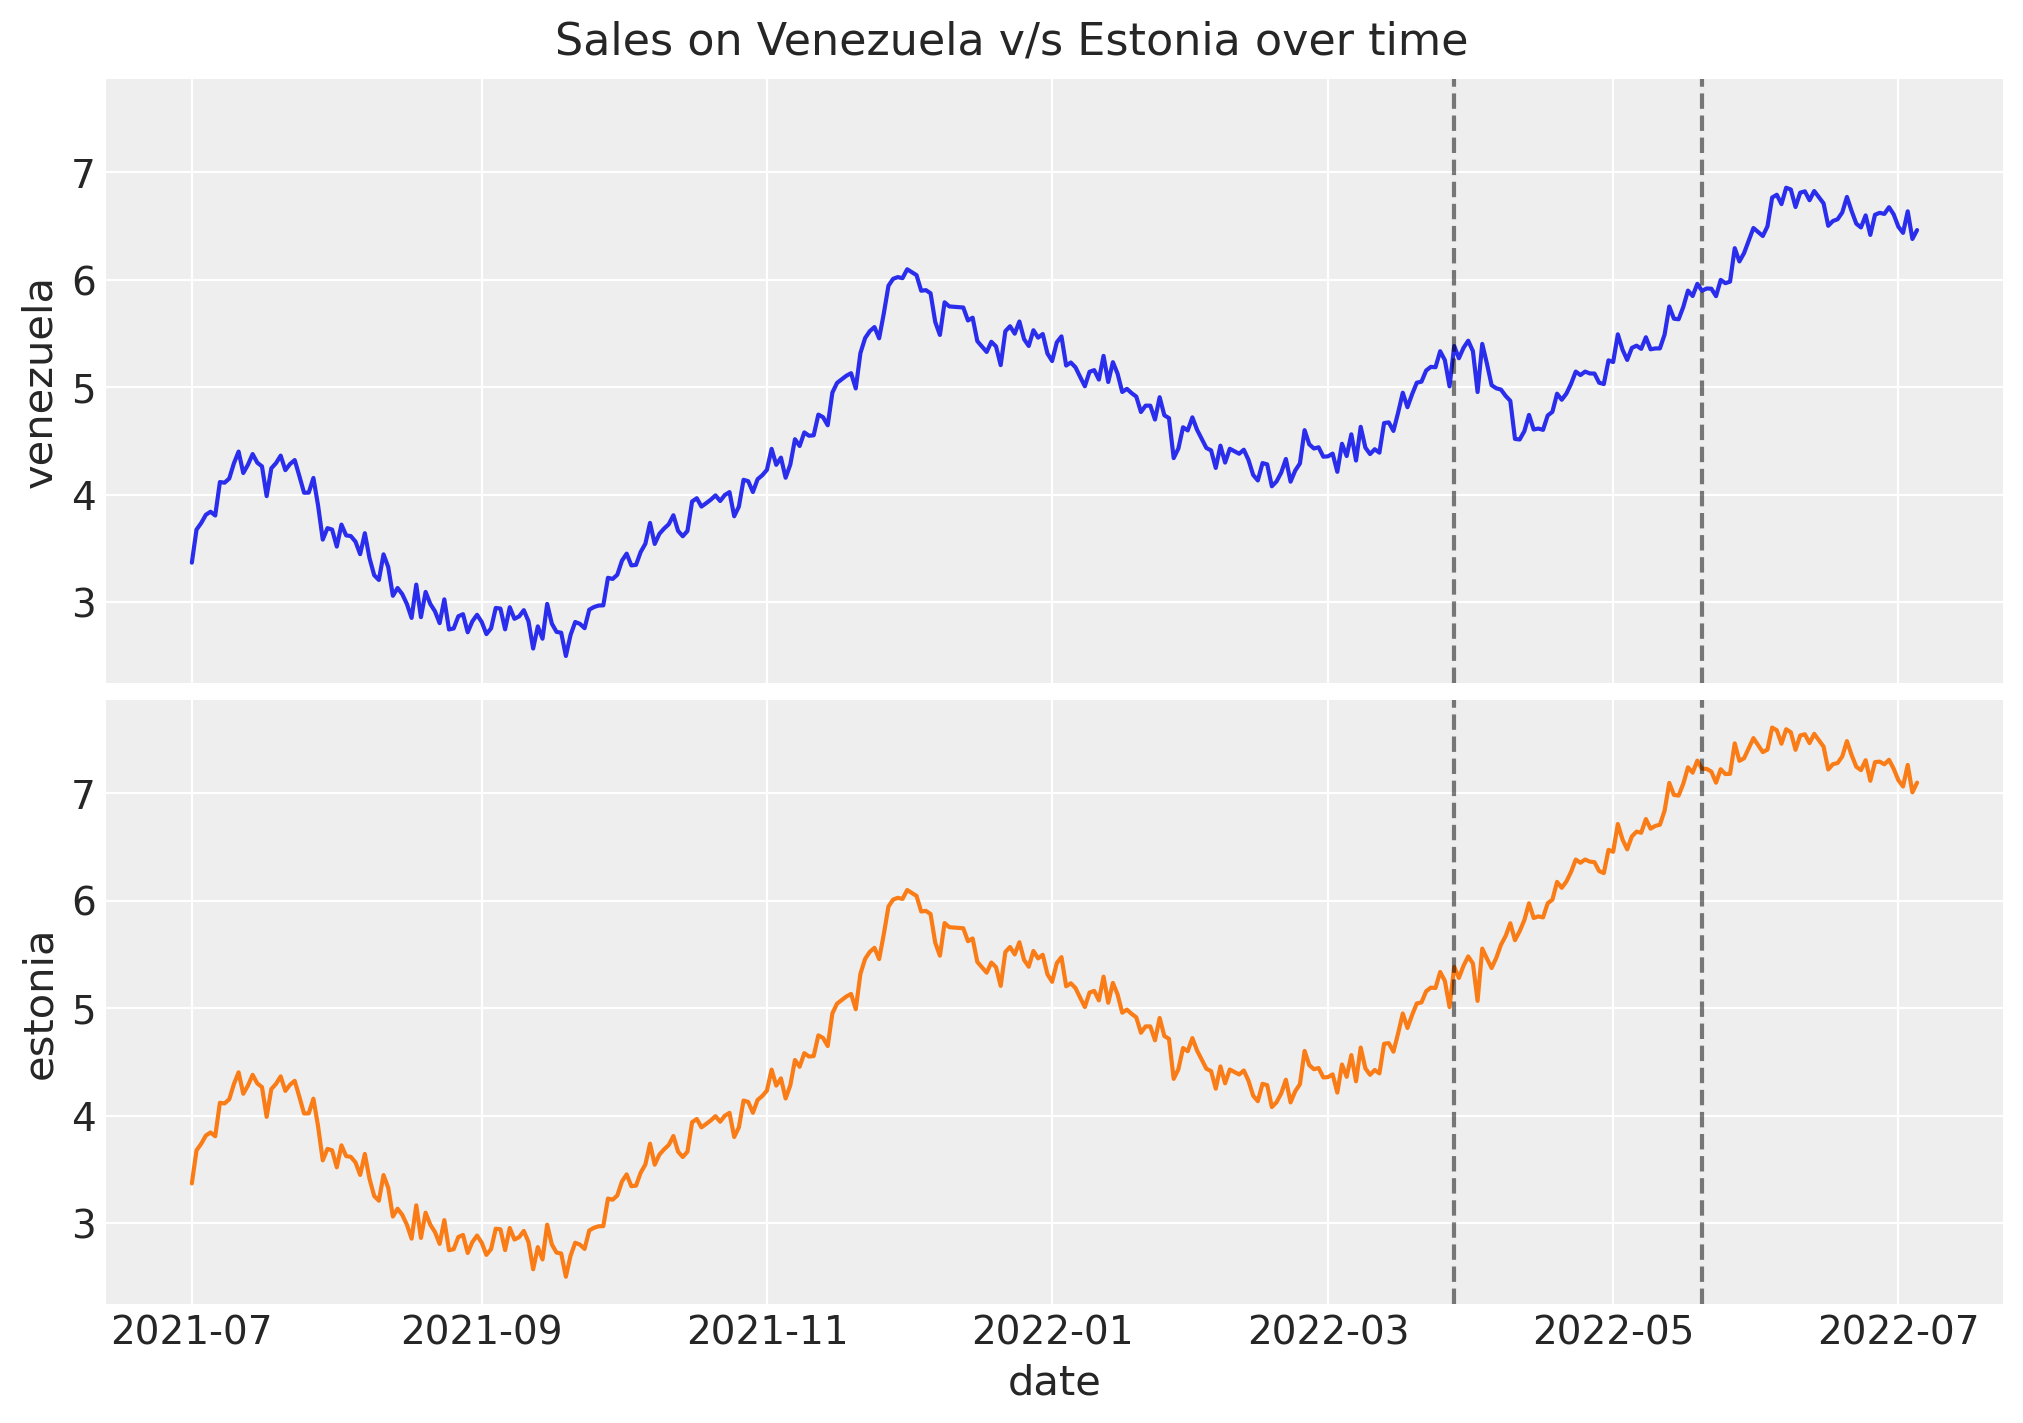

In [5]:
# Experiment Dates
start_date = pd.to_datetime("2022-03-28") #Action start date
end_date = pd.to_datetime("2022-05-20") #Action end date

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="ds", y="venezuela", data=df, color="C0", ax=ax[0])
sns.lineplot(x="ds", y="estonia", data=df, color="C1", ax=ax[1])
ax[0].axvline(start_date, color="black", linestyle="--", alpha=0.5)
ax[0].axvline(end_date, color="black", linestyle="--", alpha=0.5)
ax[1].axvline(start_date, color="black", linestyle="--", alpha=0.5)
ax[1].axvline(end_date, color="black", linestyle="--", alpha=0.5)
ax[1].set(xlabel="date")
fig.suptitle("Sales on Venezuela v/s Estonia over time", fontsize=16)
plt.show()

Notice how the sales from *Venezuela* and *Estonia* were in sync until just before the intervention period, marked by the vertical black lines, where *Venezuela* appeared to experience a decline.

Taking a simple look, we can notice that something has happened. But how can we quantify it?

## **CausalPy** to the rescue 🚀

Let’s dive into the heart of the process using a nifty tool in `CausalPy`, the `pymc_experiments.InterruptedTimeSeries` class. Think of it as your personal time travel machine, ready to dissect exactly when and how your strategies altered the course of your sales trajectory. 

The `InterruptedTimeSeries` class requires the following parameters:

- `data`: The data used to fit the model.
- `treatment_time`: The time at which the treatment was applied.
- `formula`: The formula used to fit the model.
- `model`: A PyMC Model.

Once our model is humming and all parameters are in place, we can observe the **estimated effect**. The estimated effect is the difference between the observed variable and the counterfactual variable. It represents the impact of the action (treatment) on the target variable.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 42 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


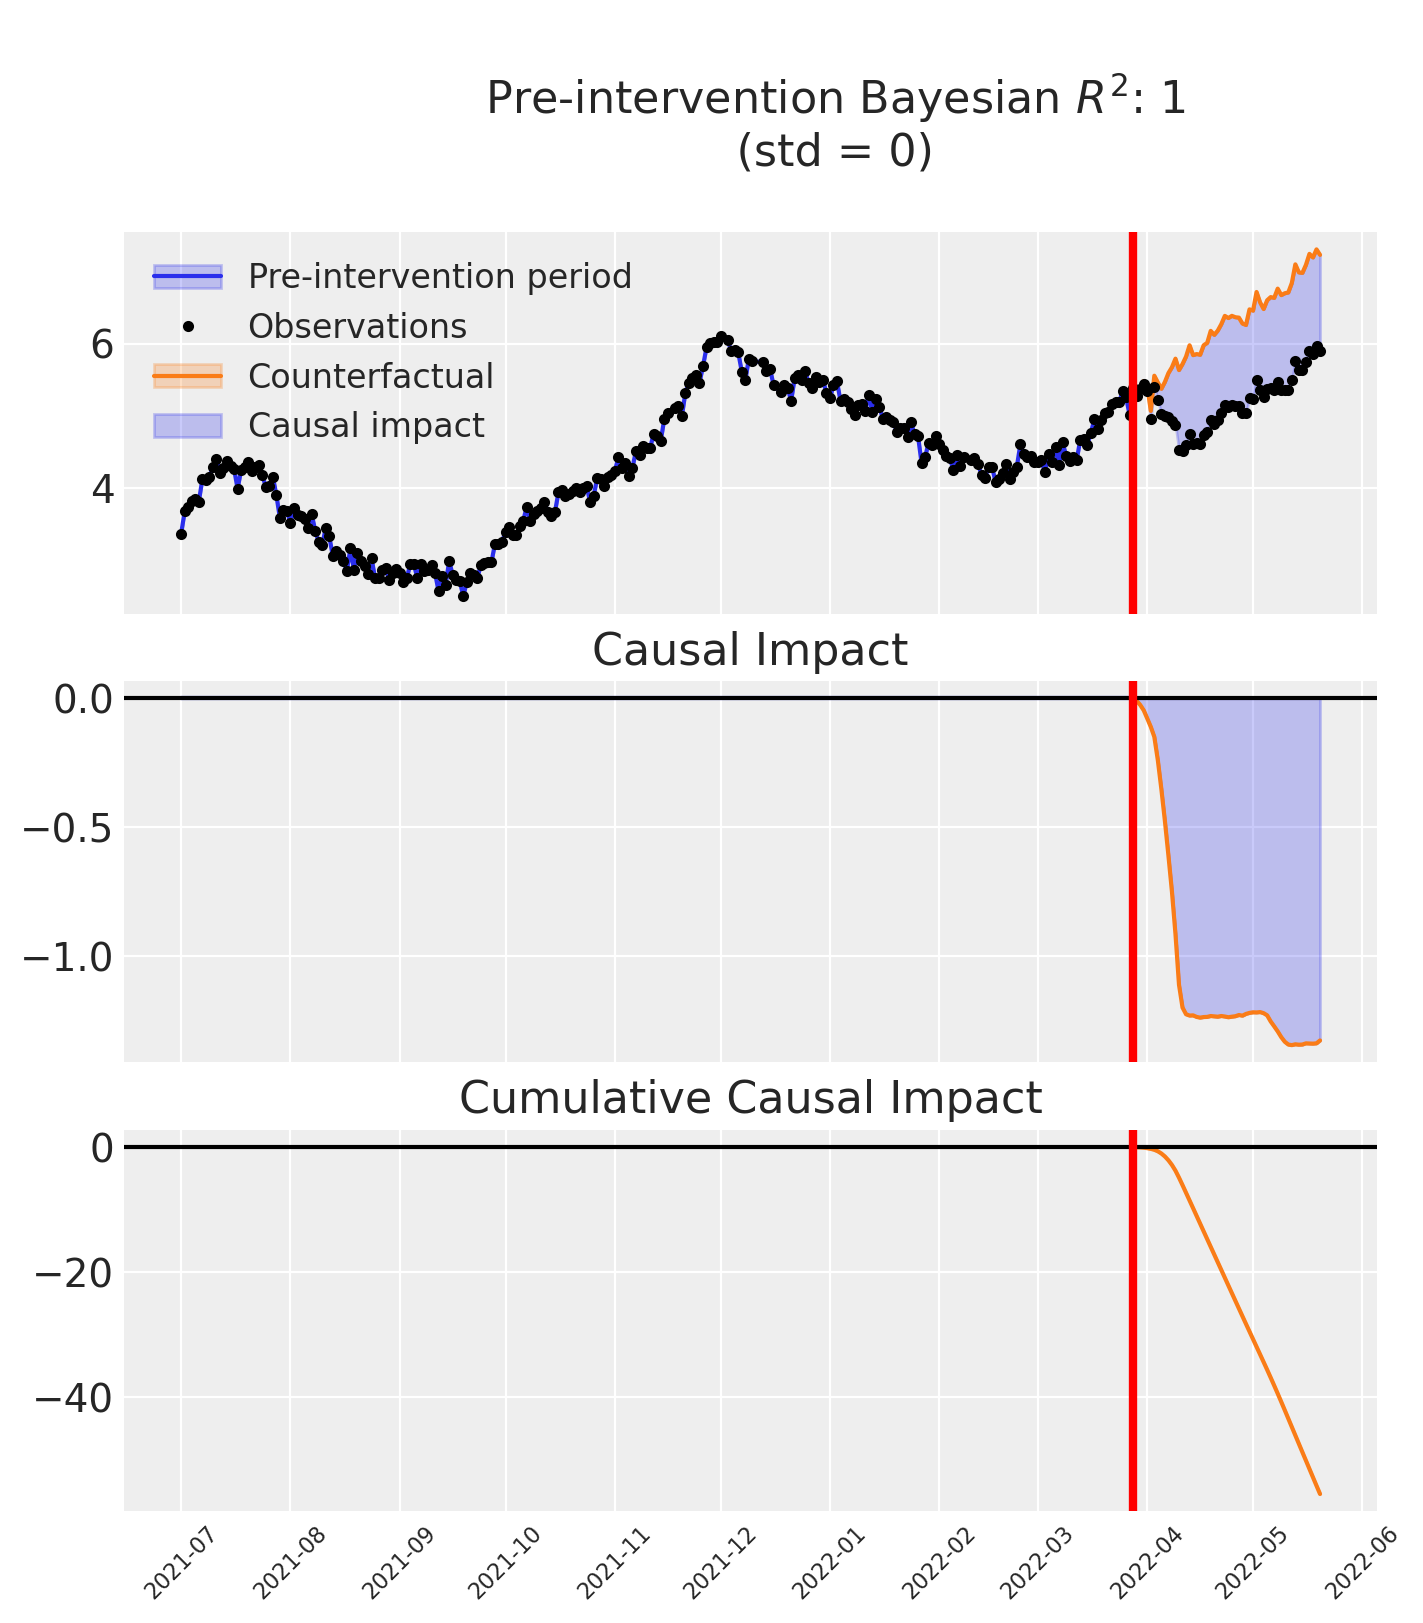

In [6]:
experiment = cp.pymc_experiments.InterruptedTimeSeries(
    data=df.query(f"ds<='{end_date}'").set_index("ds"),
    treatment_time=start_date,
    formula="venezuela ~ estonia",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed, "target_accept": 0.95, "tune": 2000}),
)

fig, ax = experiment.plot()
plt.xticks(rotation=45, fontsize=8)
plt.show()

Let's take a look about to the output. We can see a plot with three figures:

1. The initial image depicts the fit of our model before and during the intervention. It is evident from the image that prior to the intervention, the model was accurately predicting the sales in Venezuela based on the sales in Estonia. However, after the intervention, there was a noticeable divergence, leading to the appearance of a bluish delta in the figure.

2. The subsequent photo provides us with another angle of the same data. We can discern that the difference between predictions and actual sales before the intervention was zero, but after the intervention, it increased up to `-1.33`. This implies that the relationship between variables underwent a significant change after the intervention.

3. the third image portrays how the daily differences that we observed in the second photo keep accumulating over time, leading to a more pronounced effect.

As you can see, these three images allow us to reveal and quantify the impact of our actions. But I'm sure you're wondering, how can we know that these differences are actually the causal effect of our actions and not simply an error in the model estimations?

### **Quasi-Experiments considerations** ⚠️

To pinpoint the cause of any changes observed in a time series, it's super important to make sure that the model effectively controls all the factors that may impact it. The dataset used in this case was created synthetically, which made the job easier by using only "Estonia" as a predictor to capture the effect. But in real-world situations, you gotta include additional variables that account for all the different conditions that might arise during an experiment. If you don't, you might mistakenly attribute an effect to an action where there's no connection whatsoever.

Additionally, when we are conducting a **quasi-experiment**, in addition to making sure you control for the right variables, it's important to maintain the assumption that there couldn't be any other explanation for the results found. If you don't do that, the experiment's reliability goes down. We will never be able to control everything, and if there is some other reason for my change to occur, how can I be sure that my action was the cause?

To determine if your causal model is well calibrated before the experiment, here is some recommended reading.:
1. [Bayesian Power Analysis in CausalPy]()
2. [A/A Test with PyMC](https://juanitorduz.github.io/time_based_regression_pymc/)

### Estimating the total causal effect 🔬

We have estimated our causal effect with our `CausalPy` model. However, we still have to process the resulting data a bit more.

The initial step is to extract the maximum point of our effect, which is typically found at the end of our period. This will enable us to gauge the delta lost by our actions and understand the distance covered by our curve after we reduced advertising spending. We could estimate the daily difference of our effect compared to the previous day and calculate its total, in order to find this number.

In [8]:
detected_effect = (
    pd.DataFrame(experiment.post_impact.mean(dim=["chain", "draw"]).values) 
    - pd.DataFrame(experiment.post_impact.mean(dim=["chain", "draw"]).values).shift(1)
).sum().item()

print(f"Detected Cumulative effect: {detected_effect:.2f}")
# Detected Cumulative effect: -1.33

Detected Cumulative effect: -1.33


We have observed a total decrease of `-1.33` in the meta channel post-treatment. This means that we experienced a `1.33` decline in sales (`Venezuela`) after change our spend from Xt to Xt1 amount.

This point is the lost delta contribution over the period from our marketing activities in 'meta'. However, this delta was caused by the decreased delta in advertising spending in the platform. Therefore, we are going to estimate it by calculating the absolute difference in spending during the period.

In [9]:
meta_start = df.loc[df["ds"] == start_date, "meta"].values[0]
meta_end = df.loc[df["ds"] == end_date, "meta"].values[0]

delta_x = abs(meta_start - meta_end)

print("Spend before treatment:", meta_start)
print("Spend after treatment:", meta_end)
print("Delta | Change:", delta_x)

# Spend before treatment: 3.0229571428571425
# Spend after treatment: 0.3145857142857143
# Delta | Change: 2.708371428571428

Spend before treatment: 3.0229571428571425
Spend after treatment: 0.3145857142857143
Delta | Change: 2.708371428571428


This means our negative change of `2.7` units in the `meta` channel during the intervention is responsible for a decrease of `1.33` sales in *Venezuela*.

These two points represent the change on the $X$ and $Y$ axis respectively. **Our assumption is that marketing effects saturate**, and if that's the case, we can assume these points are one coordinate pair in a bigger non-linear function. Additionally, we assume that said non-linear saturation function is represented by the Michaelis Menten equation.

Since we are looking at the extra value on the $X$ axis giving an extra value on the $Y$ axis, it is natural to think about estimating the derivative. If we estimate the derivative correctly, we can then obtain the prior values that our function should have to match our experiment.

We will use `sympy` to estimate the derivative of our objective function.

In [10]:
from sympy import symbols, diff

# Define symbols
x, alpha, lam = symbols("x alpha lambda")

# Define the Michaelis-Menten equation
equation = alpha * x / (lam + x)

# Find its derivative with respect to x
derivative = diff(equation, x)

derivative

-alpha*x/(lambda + x)**2 + alpha/(lambda + x)

In [11]:
# Define the derivative of the Michaelis-Menten function based on the sympy expression.
def derivative_michaelis_menten(x, alpha, lam):
    return -alpha * x / (lam + x)**2 + alpha / (lam + x)

Let's remember that the derivative will give us the rate of change on the $Y$ axis associate to the absolute values on $X$. However, now we have absolute values for both axes, how can we convert use it then?

Average rate of change: 0.4903217844128708
X midpoint: 1.6687714285714284


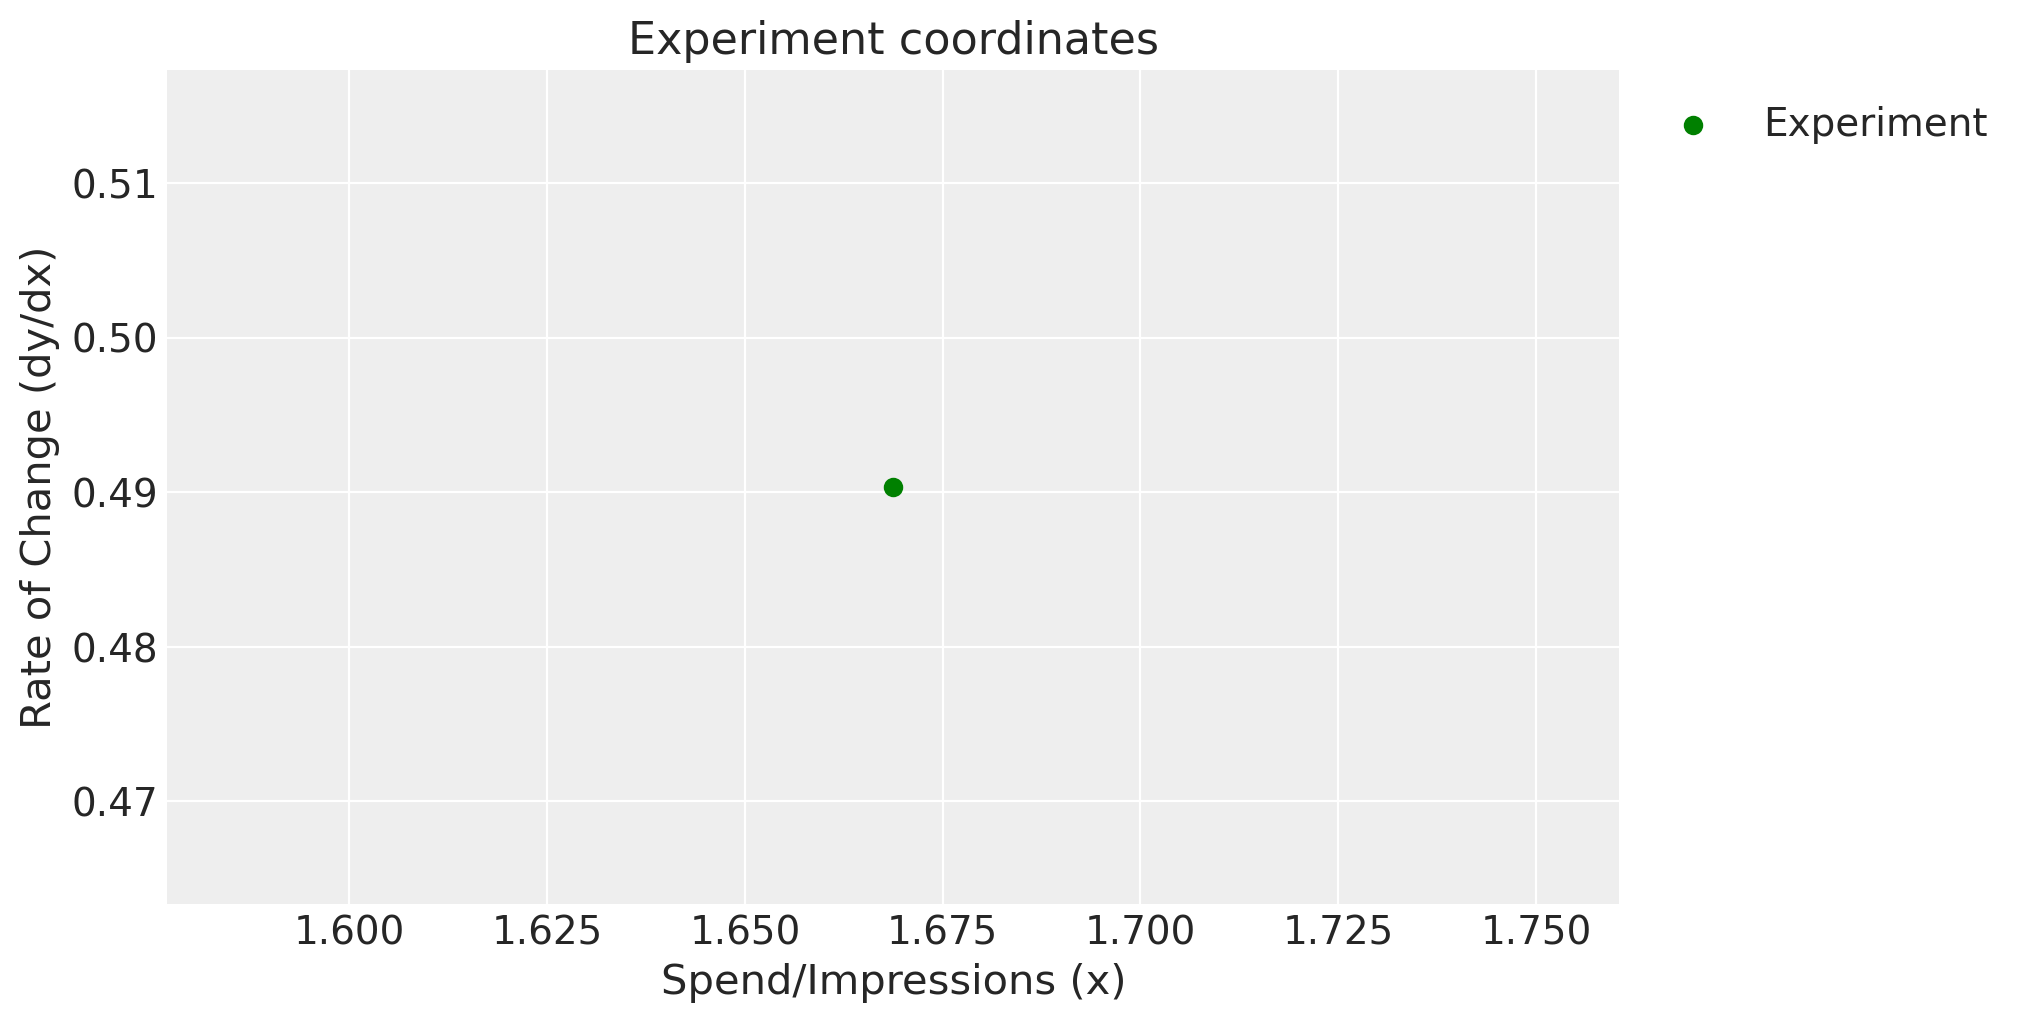

In [12]:
# Average rate of change as an estimate of the derivative
average_rate_of_change = abs(detected_effect) / delta_x
x_midpoint = (meta_end + meta_start) / 2
print("Average rate of change:", average_rate_of_change)
print("X midpoint:", x_midpoint)

# Average rate of change: 0.4903217843787133
# X midpoint: 1.6687714285714284

plt.figure(figsize=(10, 5))
plt.scatter(x_midpoint, average_rate_of_change, color="green", label="Experiment", zorder=5)
plt.xlabel("Spend/Impressions (x)")
plt.ylabel("Rate of Change (dy/dx)")
plt.title('Experiment coordinates')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

The previous calculation converts our coordinates to exist in the same two-dimensional space in which our derivative exists, we can construct a function that evaluates the best set of `alpha`, and `lam` values that match the given point.

In [13]:
# Objective function: Sum of squared differences between observed and predicted dy/dx
from scipy.optimize import minimize
def objective_function(params, x_data, y_data):
    alpha, lam = params
    y_pred = derivative_michaelis_menten(x_data, alpha, lam)
    error = np.sum((y_data - y_pred) ** 2)
    return error

The function is evaluated using the `scipy.optimize.minimize` function, if you want ot read more about it, you can check the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

In [14]:
# Single fake data point: (x, dy/dx)
x_range = np.linspace(0, 5, 100)
initial_guess = [1, 1]
experiment_data = np.array([(
    x_midpoint, average_rate_of_change
)])

# Perform optimization with a single point
result_single = minimize(objective_function, initial_guess, args=(experiment_data[:, 0], experiment_data[:, 1]), method='L-BFGS-B', bounds=[(0, None), (0, None)])

# Extract the best alpha and lambda for the single point
best_alpha_single, best_lam_single = result_single.x

# Plot the observed point and the best fit line for the single point
best_fit_y_single = derivative_michaelis_menten(x_range, best_alpha_single, best_lam_single)

print("Best Alpha for Single Point:", best_alpha_single)
print("Best Lambda for Single Point:", best_lam_single)

# Best Alpha for Single Point: 3.325
# Best Lambda for Single Point: 2.148

Best Alpha for Single Point: 3.3254882418143215
Best Lambda for Single Point: 2.1482888290689073


Great!

We have the best guess `alpha` and `lambda` parameters for our Michaelis-Menten function.

Let's observe the estimated fit for the found `lam` and `alpha`.

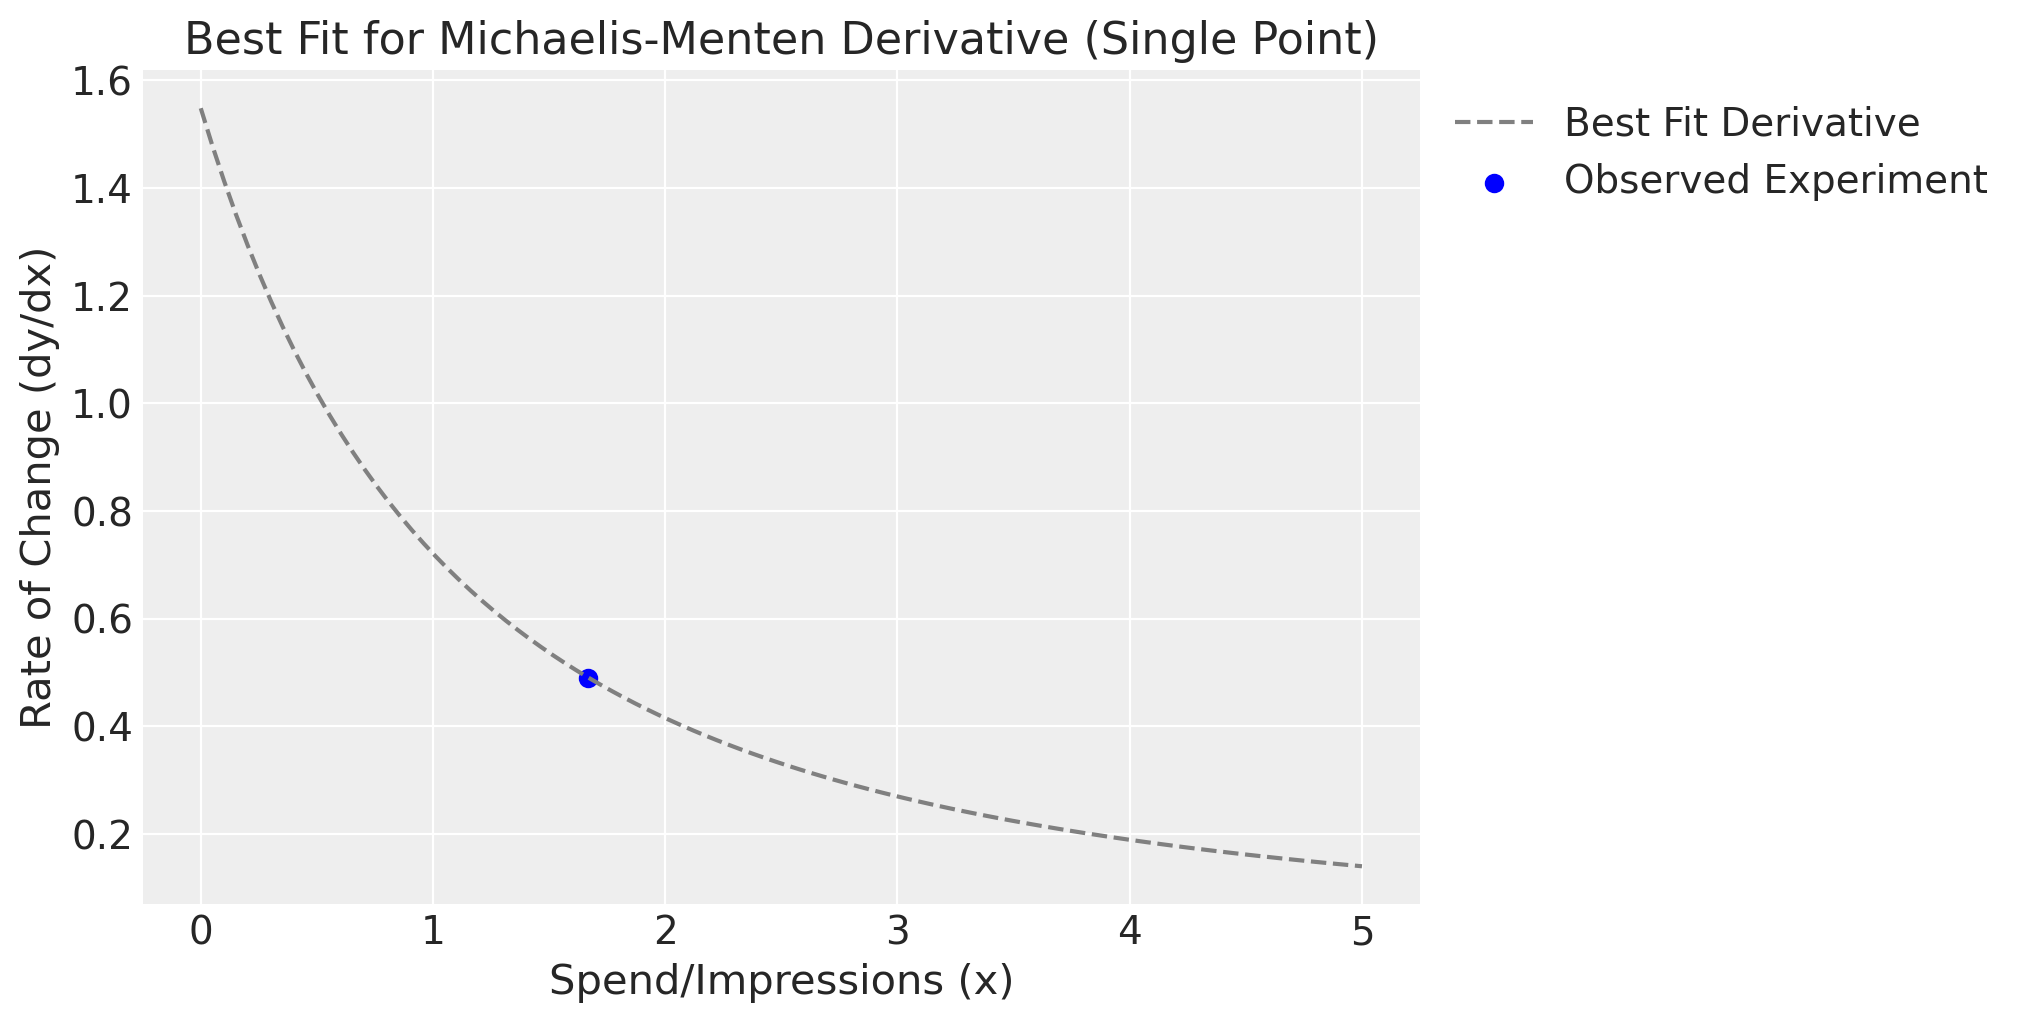

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(x_range, best_fit_y_single, label="Best Fit Derivative", color="grey", linestyle="--")
plt.scatter(experiment_data[:, 0], experiment_data[:, 1], label="Observed Experiment", color="blue")
plt.xlabel("Spend/Impressions (x)")
plt.ylabel("Rate of Change (dy/dx)")
plt.title("Best Fit for Michaelis-Menten Derivative (Single Point)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


We are getting closer to the interesting part. Let's do a little review of what has happened so far:

1. We created a model in CausalPy to estimate the change in our spending in Venezuela after reducing goal spending.
2. We calculated the maximum value of the drop in sales given the drop in advertising spending at goal.
3. We determined our best bet for the parameters of our Michaelis Menten function based on our experiment.

### Let's Model

We have our prior `lam` and `alpha` points given the experiment, it is time to start modelling. First, we must separate our regressors and target in two variables.

In [16]:
X = df[["ds", "meta", "google", "trend"]].copy()
y = df["venezuela"].copy()

Now, we will create a model in PyMC-Marketing choosing the transformations we want according to our assumptions. 

In [17]:
generic_mmm = DelayedSaturatedMMM(
    date_column = "ds", 
    channel_columns= ["meta","google"], 
    control_columns=["trend"], 
    saturation="michaelis_menten", 
    adstock="weibull_pdf", 
    adstock_max_lag = 4, 
    yearly_seasonality = 4
)

Once we have the model created, let's examine the priors that are given to the model by default.

In [18]:
generic_mmm.default_model_config

{'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'mu': 0, 'b': 1}},
 'adstock_lambda': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'adstock_shape': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'saturation_alpha': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}},
 'saturation_lambda': {'dist': 'Gamma', 'kwargs': {'mu': 1, 'sigma': 2}}}

We can notice that alpha and lam are quite wide. Let's quickly visualise using `Preliz` the distributions given for these parameters.

In [19]:
import preliz as pz

prior_alpha = pz.HalfNormal(sigma=1)
prior_lam = pz.Gamma(mu=2, sigma=1)

Gamma(mean=2.0, median=1.84, std=1.0, lower=0.58, upper=4.25)


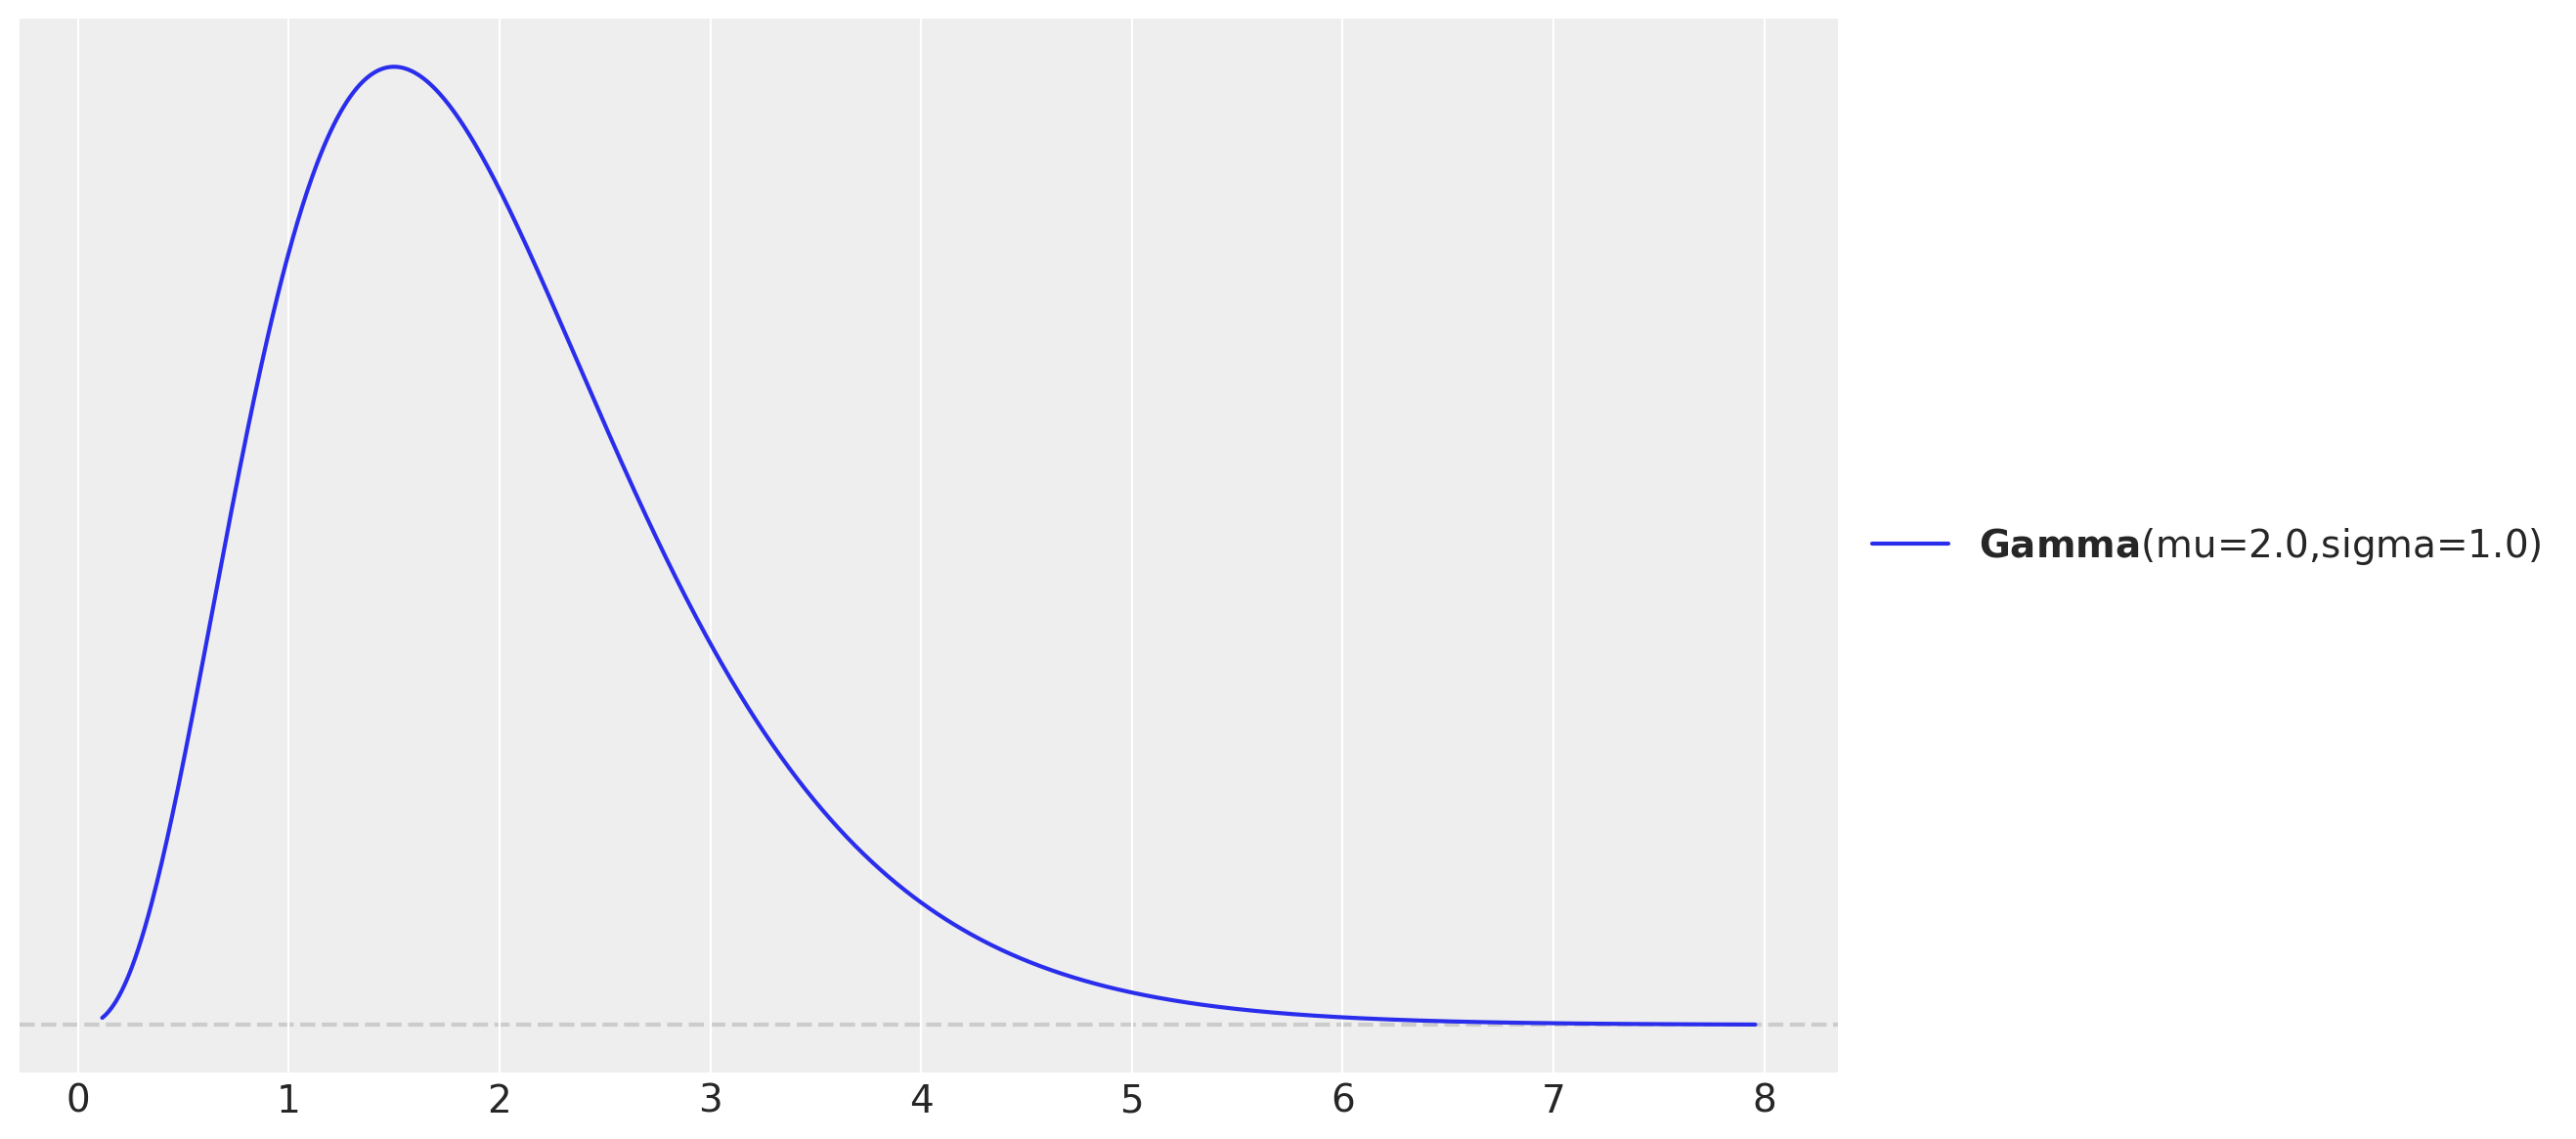

In [20]:
print(prior_lam.summary())
prior_lam.plot_pdf()
plt.show()

HalfNormal(mean=0.8, median=0.67, std=0.6, lower=0.04, upper=2.17)


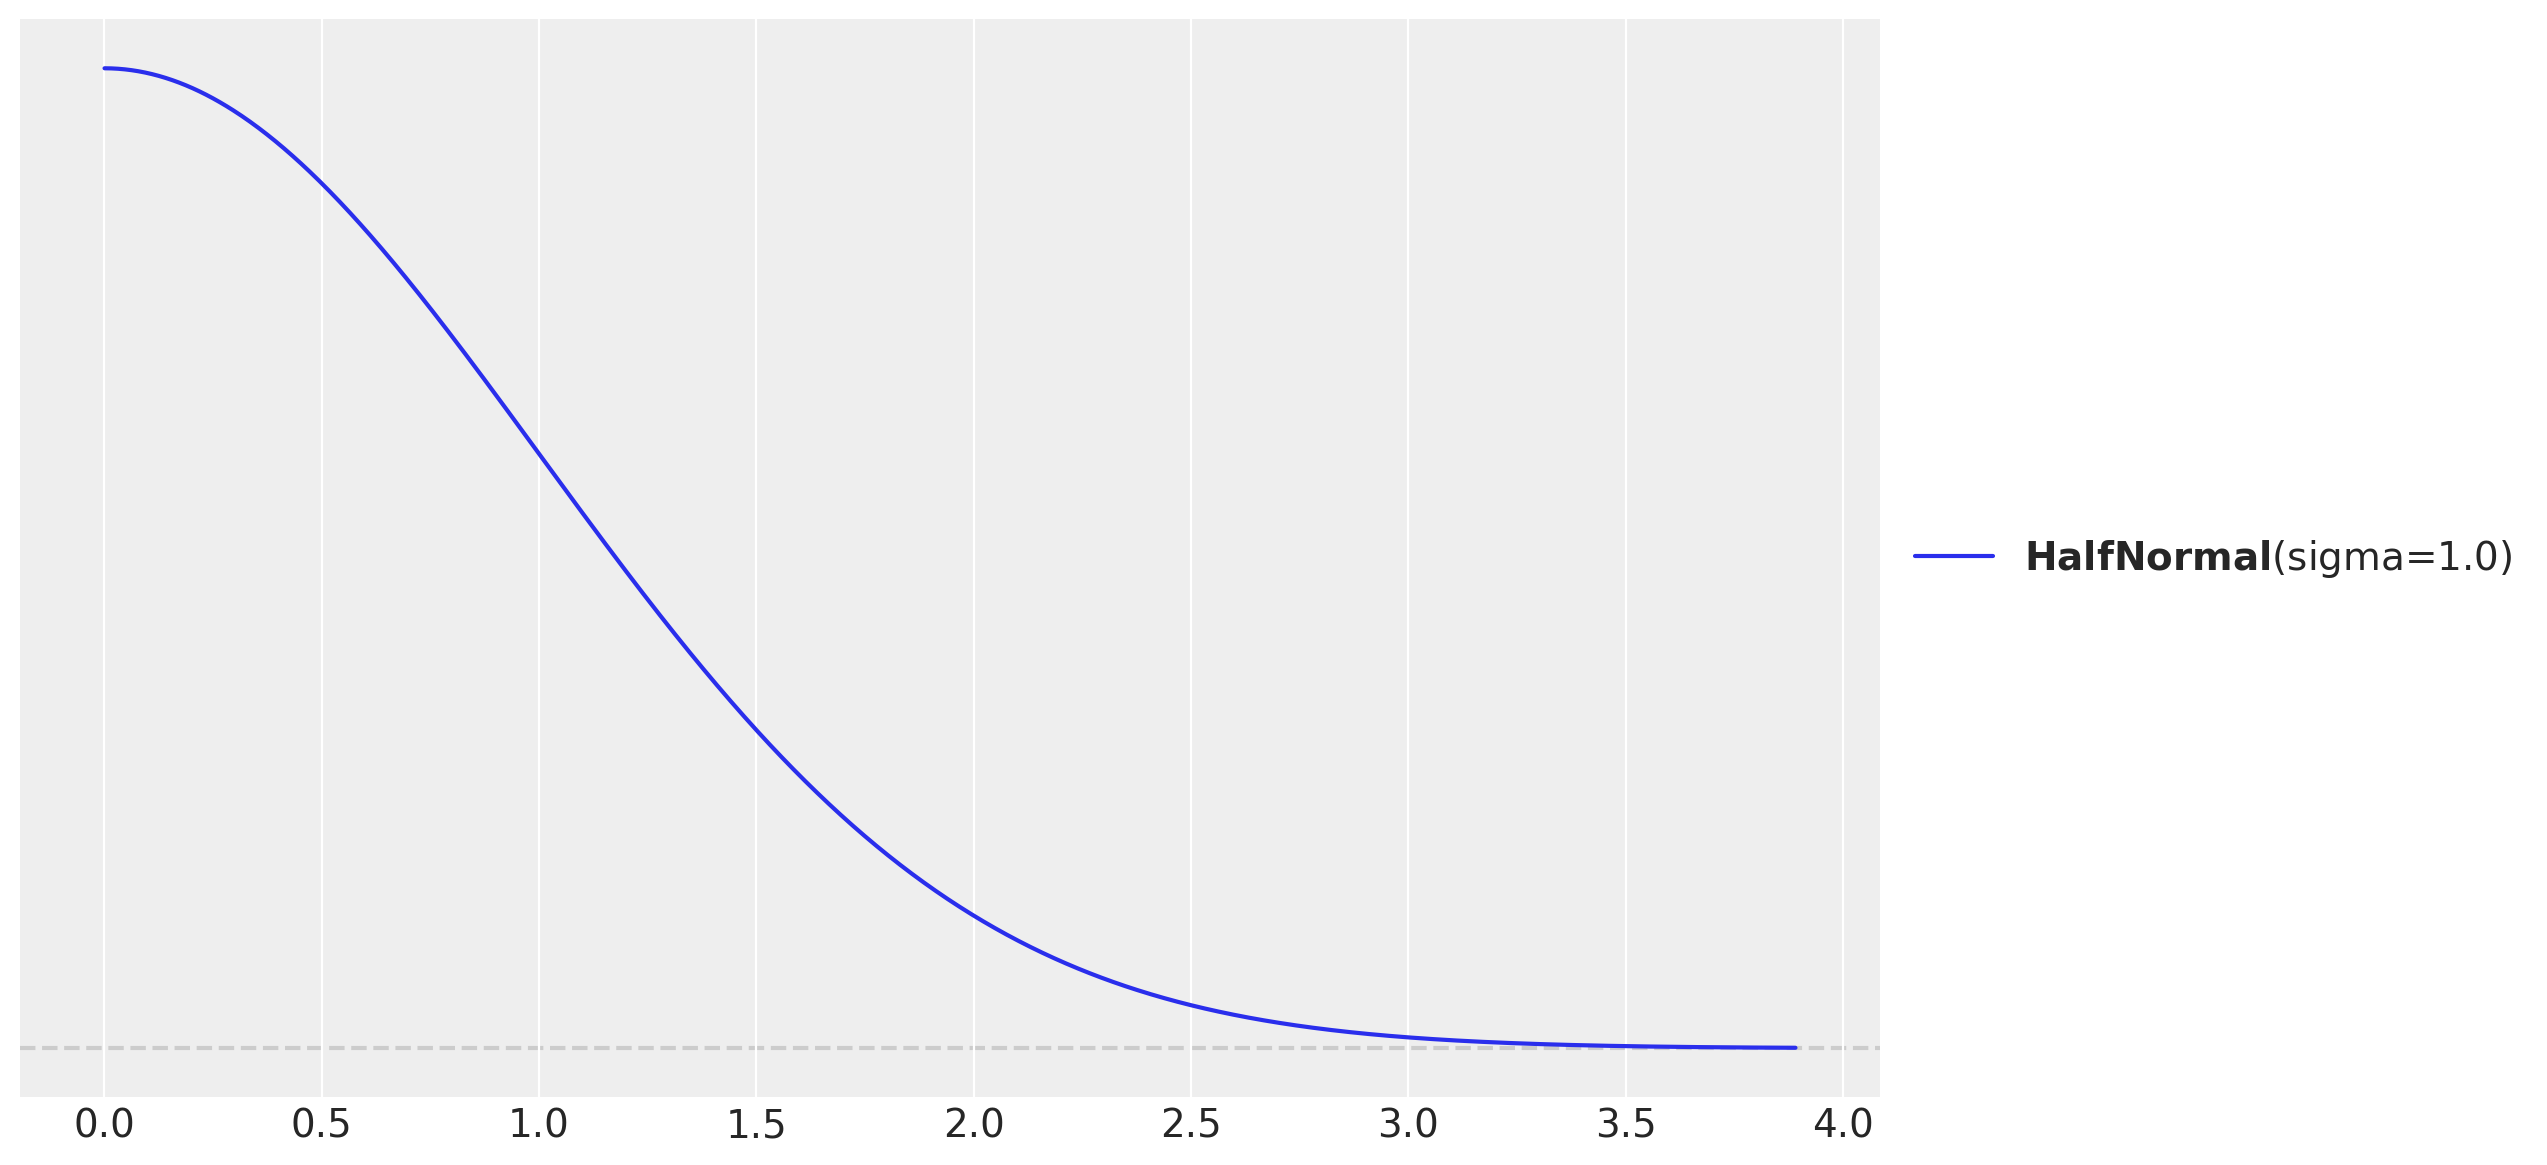

In [21]:
print(prior_alpha.summary())
prior_alpha.plot_pdf()
plt.show()

If we sample the prior parameters given to our generic model using the sample prior predictive function, we can then get an idea of our *Prior Michaelis Menten curve* and analyze how far our experiment is from its mean, given the prior distributions.

In [22]:
generic_mmm.build_model(X,y)

with generic_mmm.model:
    prior_predictive = pm.sample_prior_predictive(
        random_seed=seed,
        var_names=["saturation_alpha", "saturation_lambda"]
    )

Sampling: [saturation_alpha, saturation_lambda]


In [23]:
prior_alpha_mean = prior_predictive.prior["saturation_alpha"].mean().item()
prior_lambda_mean = prior_predictive.prior["saturation_lambda"].mean().item()

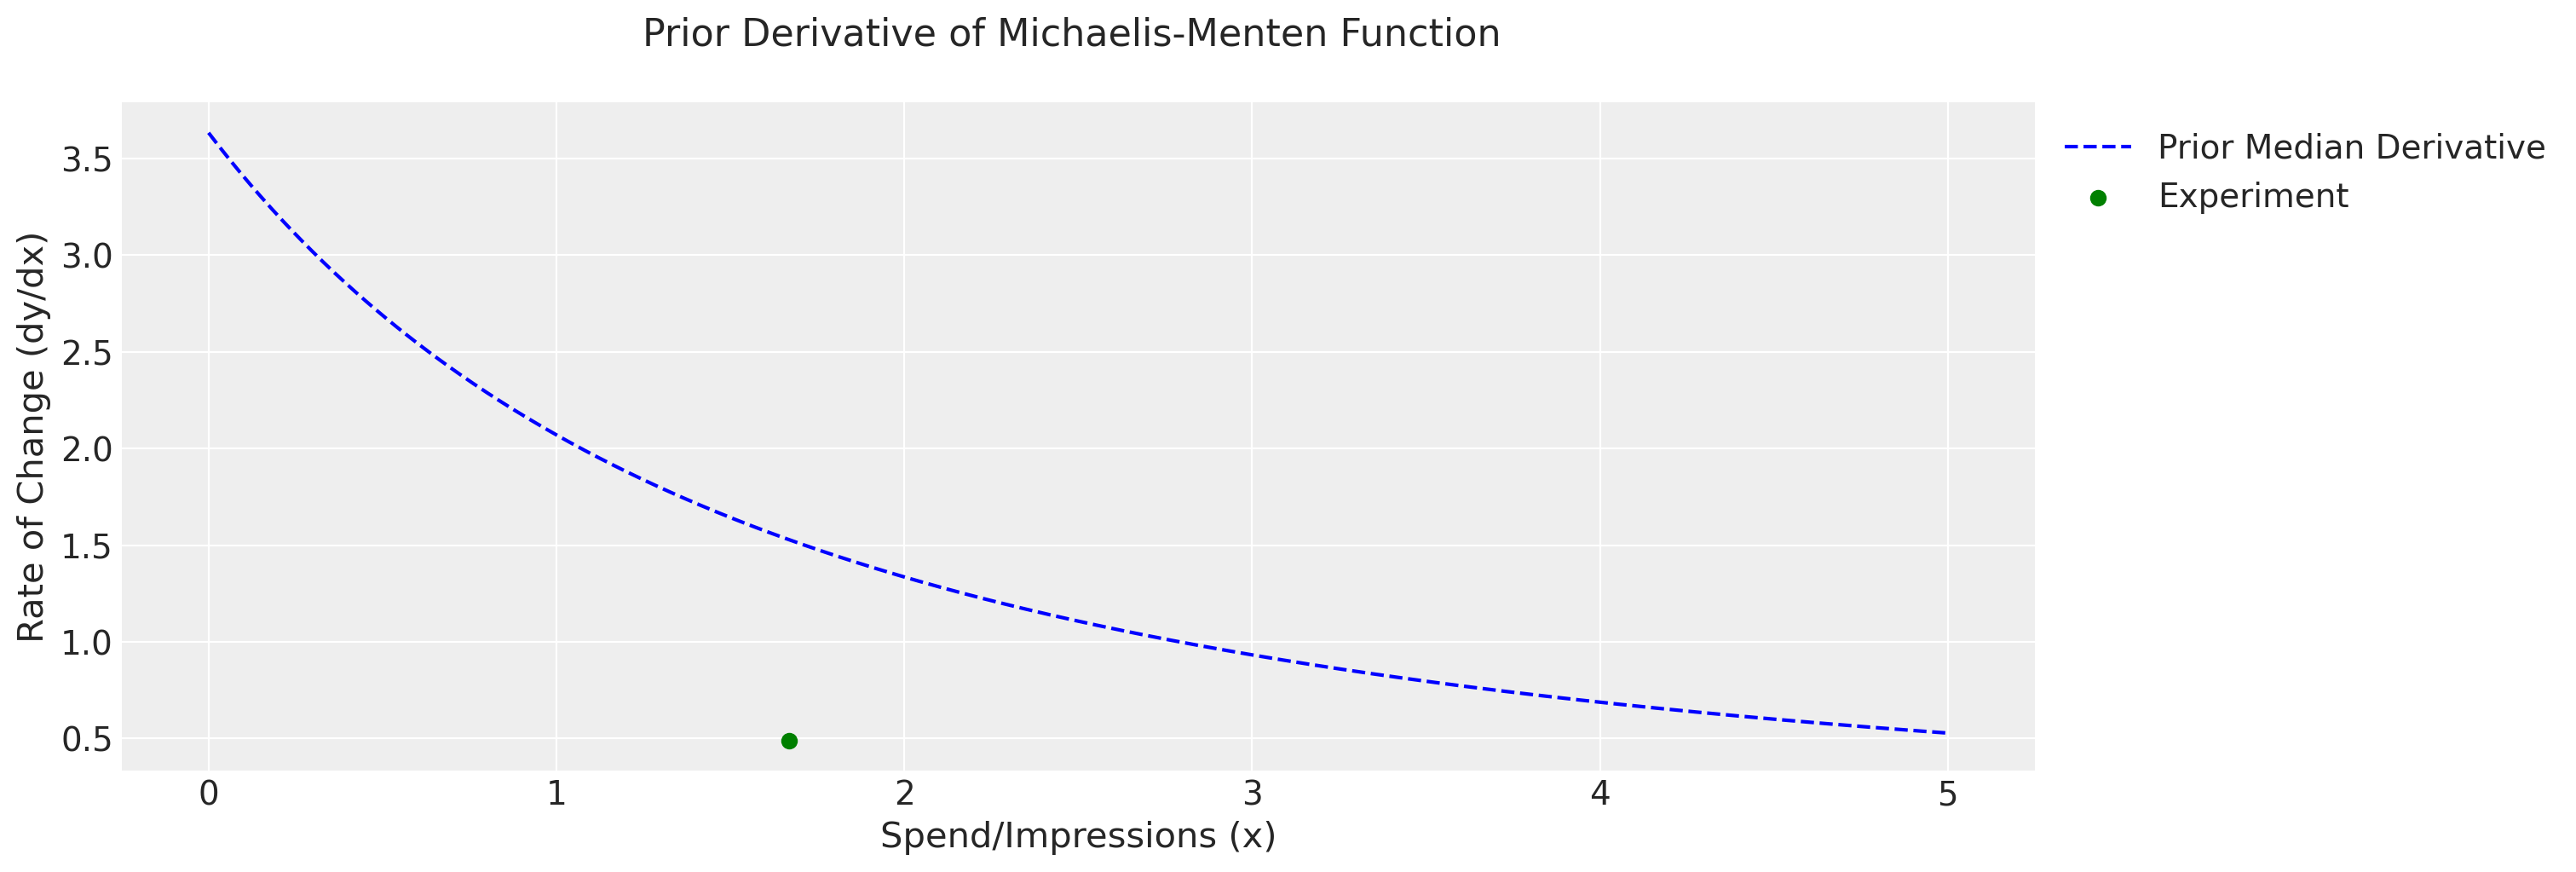

In [24]:
x_values = np.linspace(0, 5, 500)
prior_mm_mean_derivative = derivative_michaelis_menten(
    x_values, 
    alpha=(prior_alpha_mean * df.venezuela.max()), 
    lam=(prior_lambda_mean * df.meta.max())
)

plt.figure(figsize=(15, 5))
plt.plot(
    x_values, prior_mm_mean_derivative, 
    color="Blue", label="Prior Median Derivative", linestyle='--'
)

plt.scatter(
    x_midpoint, abs(average_rate_of_change), 
    color="green", label="Experiment", zorder=5
)
plt.xlabel("Spend/Impressions (x)")
plt.ylabel("Rate of Change (dy/dx)")
plt.title("Prior Derivative of Michaelis-Menten Function \n")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


The previous Michaelis-Menten (Saturation) curve's derivative, given by the mean of prior distributions for each parameter, is far from our experiment, as expected.

Let's create our own prior distributions based on the estimated `alpha` and `lam` given by the experiment.

In order to proceed, it is necessary to scale the values. It's important to remember that **our model internally scales the values using Max Abs Scaler**. This means that the values are divided by their maximum. If `alpha` is on the Y-axis and `lam` is on the X-axis, we need to scale them accordingly before passing them on to the model.

> **Note**: For this reason we multiply the values prior given by the model because these are being using as scaled.

In [25]:
scaled_alpha_prior = best_alpha_single / df.venezuela.max()
scaled_lam_prior = best_lam_single / df.meta.max()
print(f"Alpha prior Original Scale: {best_alpha_single:.2f}, Lambda prior Original Scale: {best_lam_single:.2f}")
print(f"Alpha prior: {scaled_alpha_prior:.2f}, Lambda prior: {scaled_lam_prior:.2f}")

Alpha prior Original Scale: 3.33, Lambda prior Original Scale: 2.15
Alpha prior: 0.48, Lambda prior: 0.70


Now that we are operating in a scaled space, we have noticed that both the values of `alpha` and `lam` lie within a range of 0 to 1. Therefore, we can make use of a Beta distribution, which is limited to positive values and has a range between 0 and 1.

The beta distribution can be characterised by two parameters, namely `alpha` and `beta`. To obtain a distribution with a mean around the scaled saturation values of `lam` and `alpha`, we need to identify a suitable combination of these parameters. This same logic can be applied with any type of distribution. 

You can easily find these values using the PyMC function `find_constrained_prior`. Let's take an example: we want to set the prior for the alpha parameter in Michaelis Menten's function to around 0.48. Using this function, we can look for a set of values that will give us a distribution where most of its mass is between `0.3` and `0.5`.

Let's check the following code!

In [26]:
alpha_custom_prior = pm.find_constrained_prior(
    pm.Beta, lower=0.3, upper=0.5, init_guess={"alpha": 2, "beta": 3}
)

lam_custom_prior = pm.find_constrained_prior(
    pm.Beta, lower=0.6, upper=0.9, init_guess={"alpha": 1, "beta": 3}
)

print(f"Custom prior parameter for Alpha Saturation (Beta distribution): {alpha_custom_prior}")
print(f"Custom prior parameter for Lambda Saturation (Beta distribution): {lam_custom_prior}")

Custom prior parameter for Alpha Saturation (Beta distribution): {'alpha': 36.03088851373635, 'beta': 55.87769954065099}
Custom prior parameter for Lambda Saturation (Beta distribution): {'alpha': 21.88328996404308, 'beta': 6.78635411045391}


As usual let's see the new distributions with Preliz.

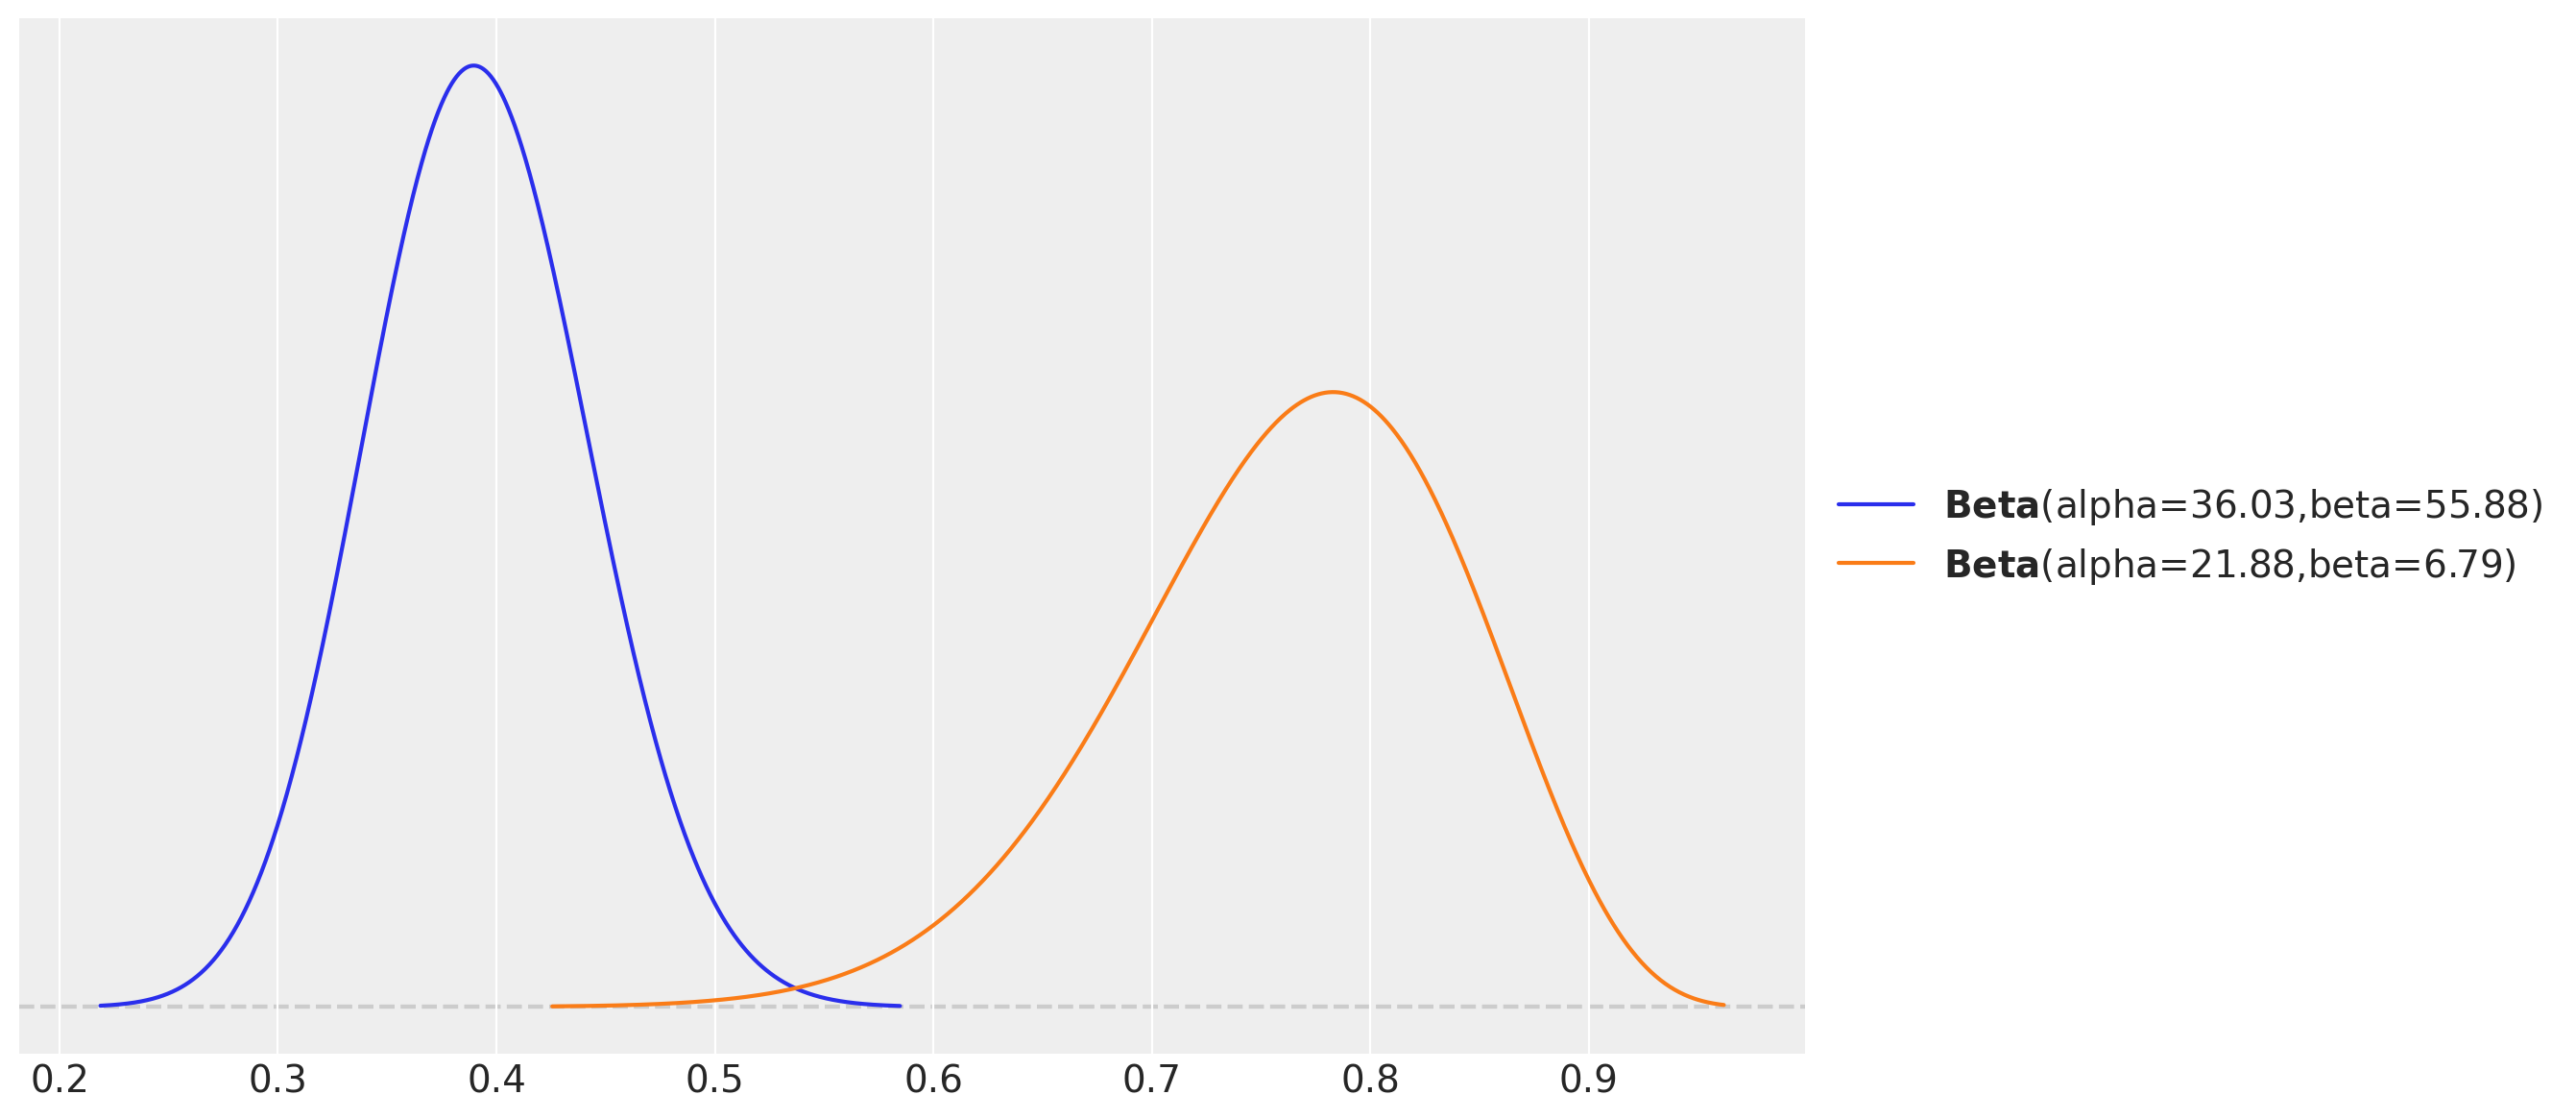

In [27]:
custom_prior_alpha = pz.Beta(**alpha_custom_prior)
custom_prior_lam = pz.Beta(**lam_custom_prior)

custom_prior_alpha.plot_pdf()
custom_prior_lam.plot_pdf()
plt.show()

The new distributions look much better now! Since we know the actual values of the function parameters, it's easy to compare and see how similar the custom and generic prior distributions are to the actual values.

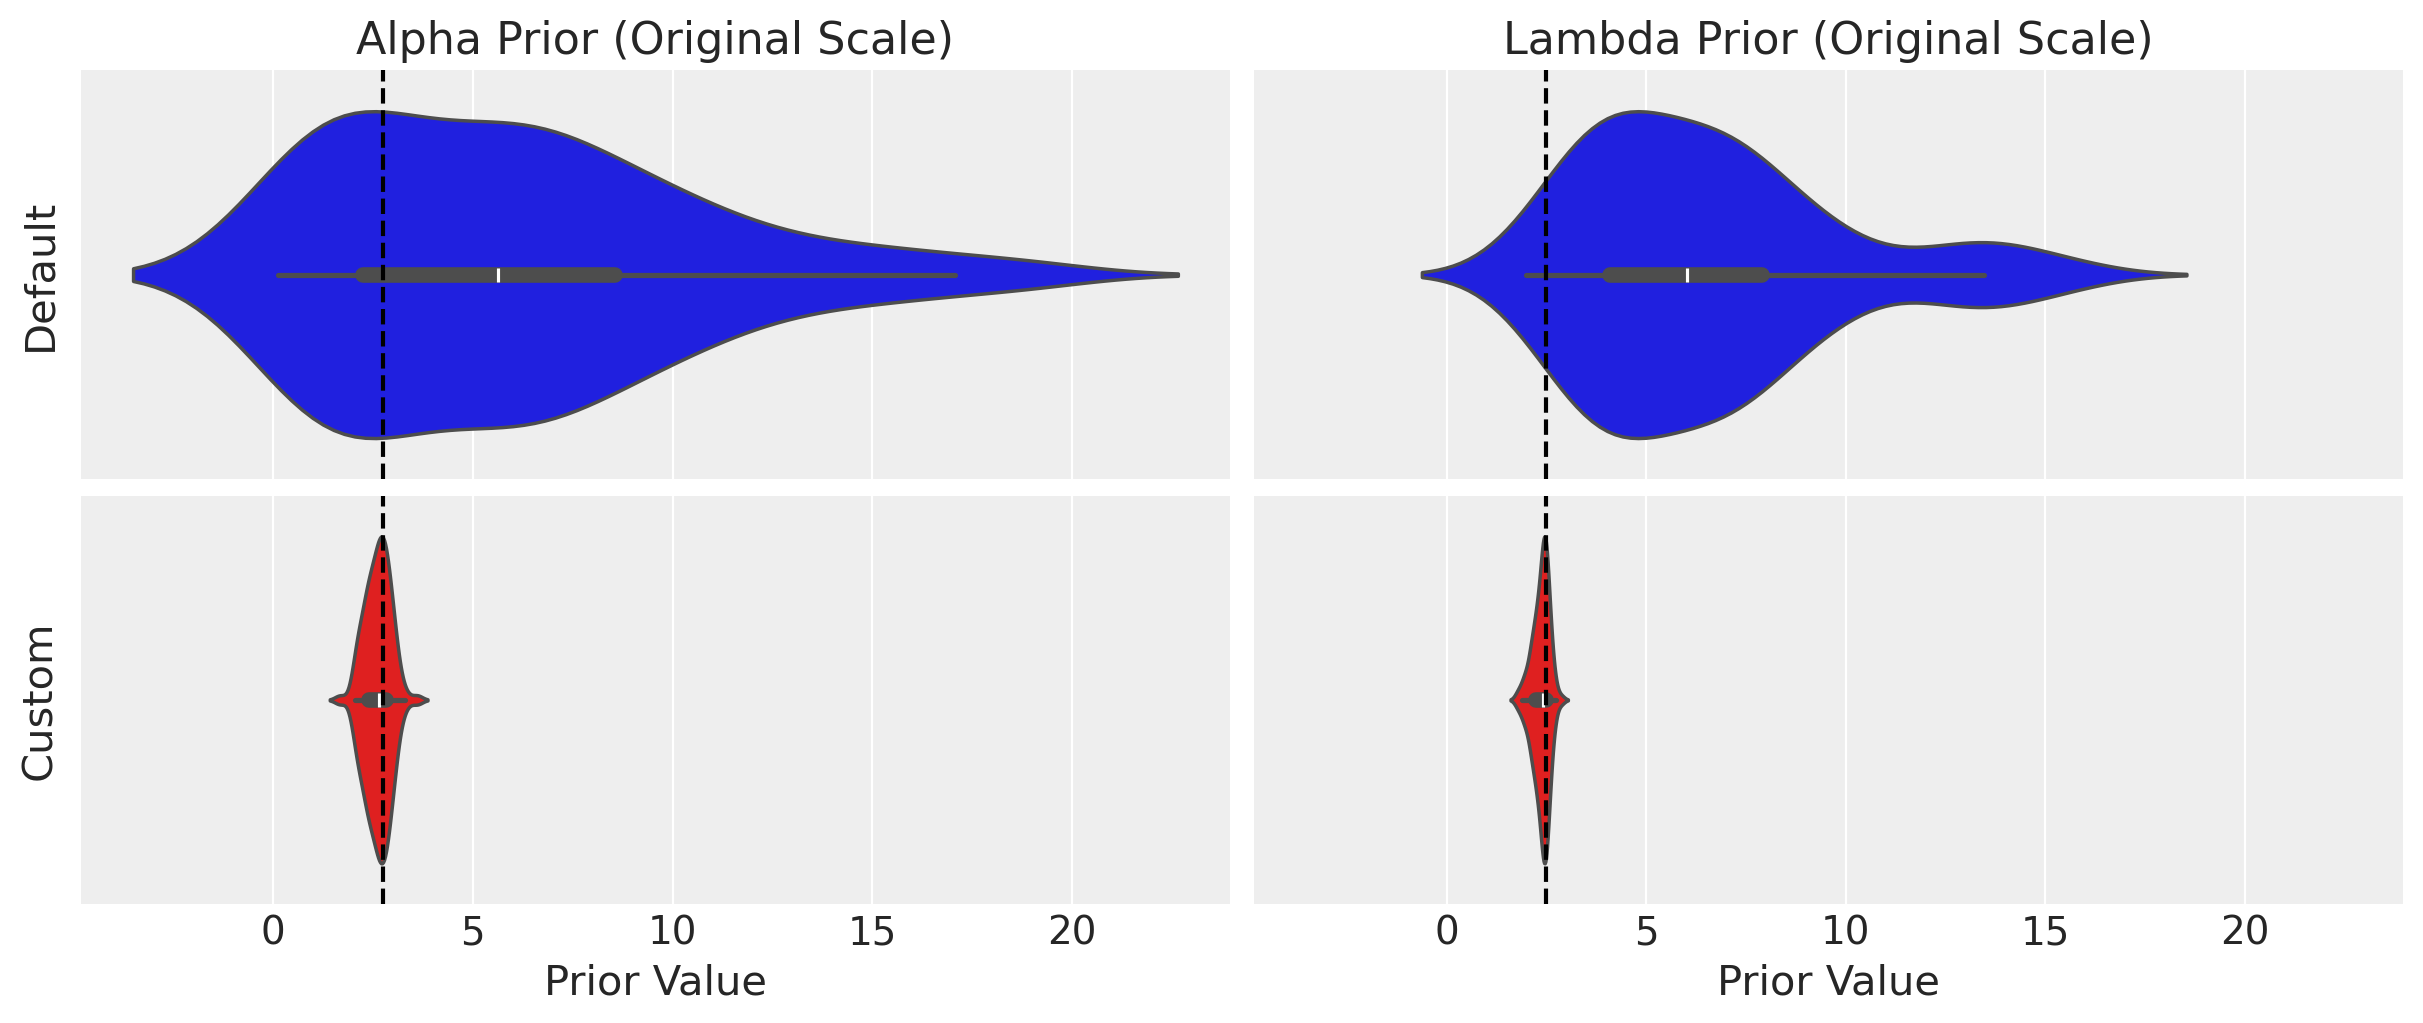

In [28]:
n_samples = 100
# default prior original scale
default_alpha_prior_orignal_scale = prior_alpha.rvs(n_samples) * df.venezuela.max()
default_lam_prior_orignal_scale = prior_lam.rvs(n_samples) * df.meta.max()
# custom prior original scale
custom_alpha_prior_original_scale = custom_prior_alpha.rvs(n_samples) * df.venezuela.max()
custom_lam_prior_original_scale = custom_prior_lam.rvs(n_samples) * df.meta.max()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 5), sharex=True, sharey=True)
sns.violinplot(data=default_alpha_prior_orignal_scale, color="blue", orient="h", ax=ax[0][0], label="prior Alpha defult")
sns.violinplot(data=default_lam_prior_orignal_scale, color="blue", orient="h", ax=ax[0][1], label="prior Lam default")

sns.violinplot(data=custom_alpha_prior_original_scale, color="red", orient="h", ax=ax[1][0], label="prior Alpha custom")
sns.violinplot(data=custom_lam_prior_original_scale, color="red", orient="h", ax=ax[1][1], label="prior Lam custom")

# Vertical lines for the true values
ax[0][0].axvline(2.75, color="black", linestyle="--")
ax[0][1].axvline(2.50, color="black", linestyle="--")

ax[1][0].axvline(2.75, color="black", linestyle="--")
ax[1][1].axvline(2.50, color="black", linestyle="--")

ax[0][0].set(title="Alpha Prior (Original Scale)",)
ax[0][1].set(title="Lambda Prior (Original Scale)",)

ax[1][0].set(xlabel="Prior Value")
ax[1][1].set(xlabel="Prior Value")

#add name on the Y axis column row 0
ax[0][0].set(ylabel="Default")
ax[1][0].set(ylabel="Custom")
plt.show()

Our new distributions are now more informative than before. We will pass this information to our model using the **model config** parameter, which receives a dictionary.

In [29]:
custom_model_config = {
    "saturation_alpha": {
        "dist": "Beta",
        "kwargs":{
            "alpha":np.array([alpha_custom_prior["alpha"], 1.8]), 
            "beta": np.array([alpha_custom_prior["beta"], 2])
            },
        },
    "saturation_lambda": {
        "dist": "Beta",
        "kwargs":{
            "alpha":np.array([lam_custom_prior["alpha"], 1.8]), 
            "beta": np.array([lam_custom_prior["beta"], 2])
            },
        },
}

model_config = {**generic_mmm.default_model_config, **custom_model_config}

Now we have our priors in place to be used by the model.

Even with just one single point of experimentation, our model can now utilise greater knowledge to converge to the actual causal relationship between our target and the marketing actions. 

Let's create a new model!

In [30]:
mmm = DelayedSaturatedMMM(
    date_column = "ds", 
    channel_columns= ["meta","google"], 
    control_columns=["trend"], 
    saturation="michaelis_menten", 
    adstock="weibull_pdf", 
    adstock_max_lag = 4, 
    yearly_seasonality = 4,
    model_config=custom_model_config
)

Let's take one final look at the custom priors we've derived before we proceed with model training. We can compare our derivative of the Michaelis Menten function with the new priors against the generic ones provided by the model to see how they measure up.

In [31]:
mmm.build_model(X,y)

with mmm.model:
    custom_prior_predictive = pm.sample_prior_predictive(
        random_seed=seed,
        var_names=["saturation_alpha", "saturation_lambda"]
    )

Sampling: [saturation_alpha, saturation_lambda]


As before we have to sample using the `sample_prior_predictive` function. Now using the new model.

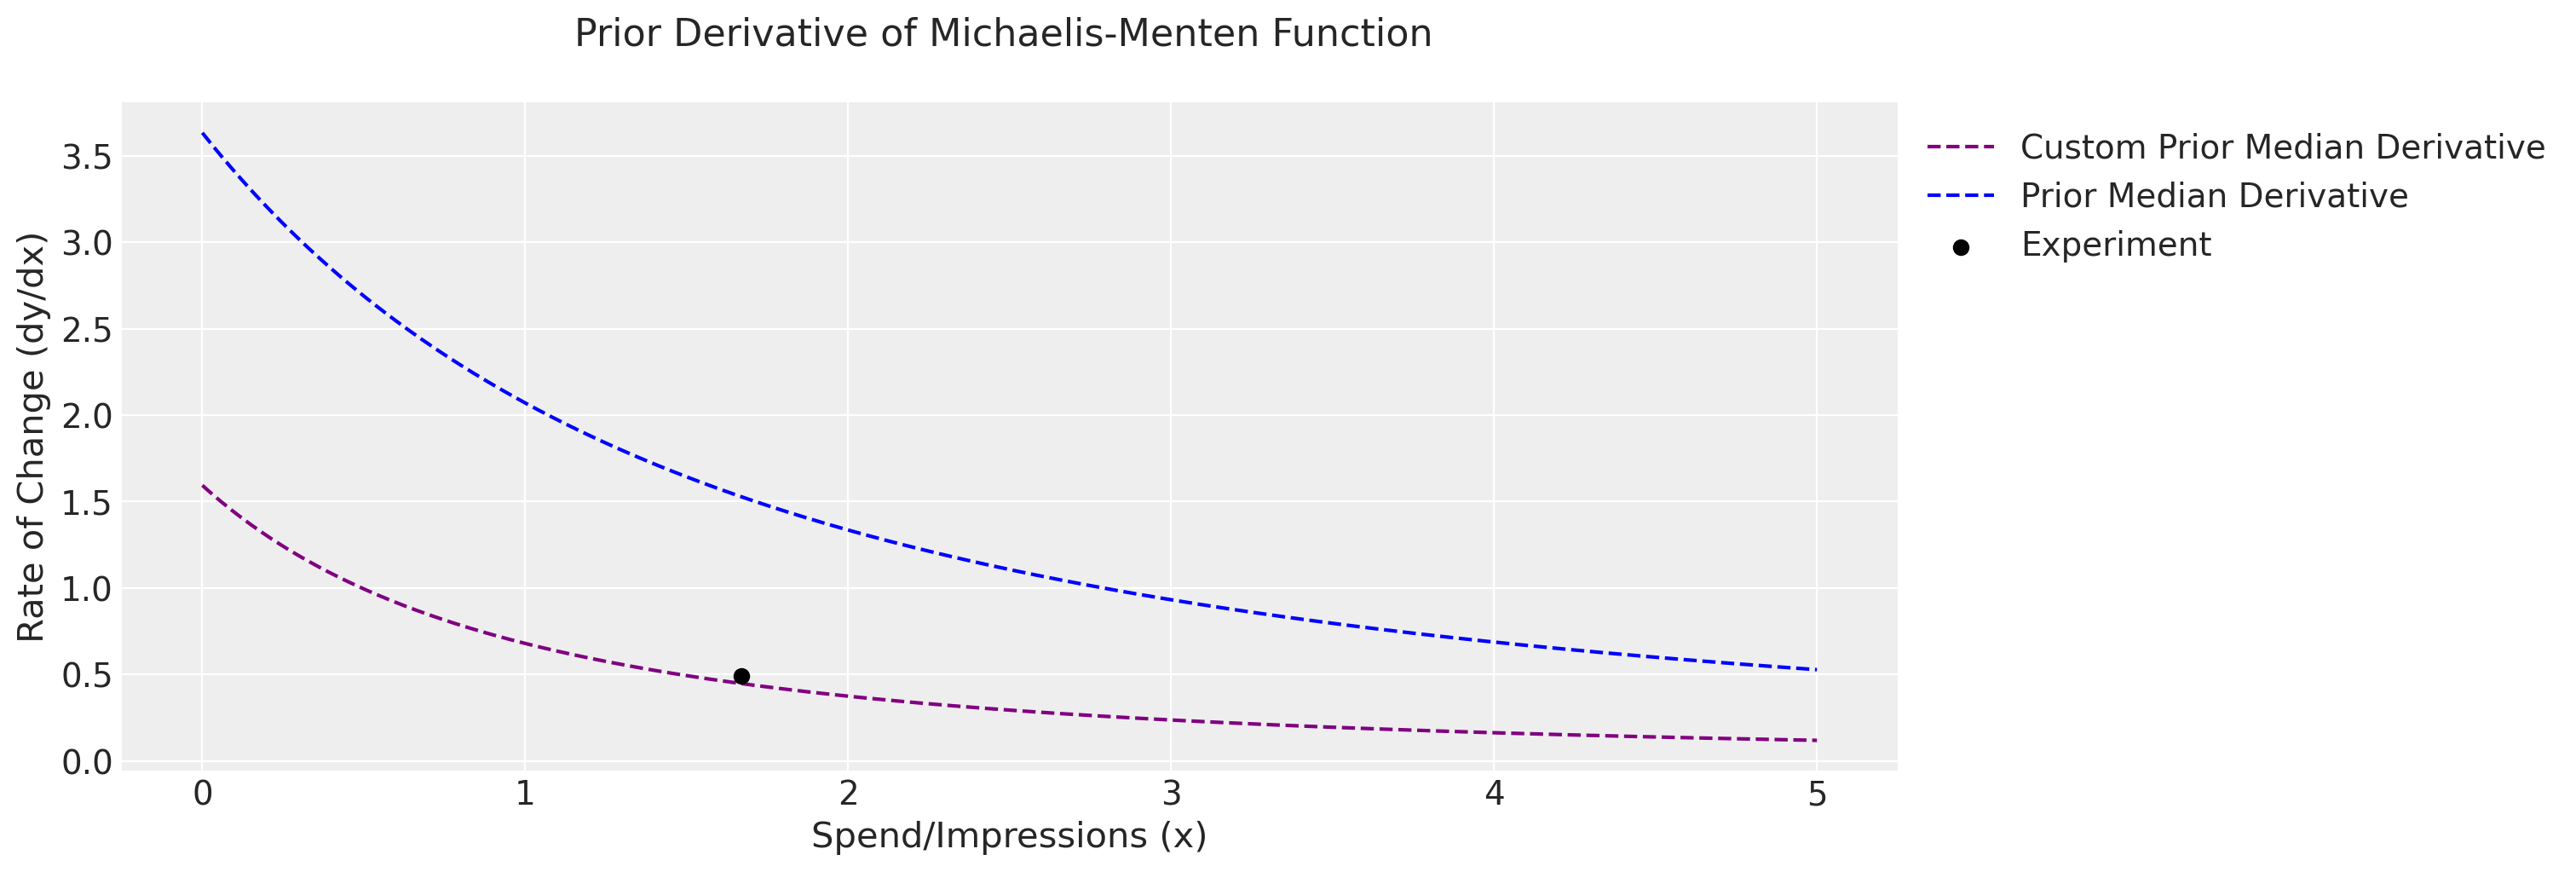

In [32]:
custom_prior_alpha_mean = custom_prior_predictive.prior["saturation_alpha"].mean().item()
custom_prior_lambda_mean = custom_prior_predictive.prior["saturation_lambda"].mean().item()

# x_values = np.linspace(0, 5, 500)
custom_prior_mm_mean_derivative = derivative_michaelis_menten(
    x_values, 
    alpha=(custom_prior_alpha_mean * df.venezuela.max()), 
    lam=(custom_prior_lambda_mean * df.meta.max())
)

plt.figure(figsize=(15, 5))
plt.plot(
    x_values, custom_prior_mm_mean_derivative, 
    color="purple", label="Custom Prior Median Derivative", linestyle="--"
)

plt.plot(
    x_values, prior_mm_mean_derivative, 
    color="blue", label="Prior Median Derivative", linestyle="--"
)

plt.scatter(
    x_midpoint, abs(average_rate_of_change), 
    color="black", label="Experiment", zorder=5
)
plt.xlabel("Spend/Impressions (x)")
plt.ylabel("Rate of Change (dy/dx)")
plt.title("Prior Derivative of Michaelis-Menten Function \n")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


As expected, the new derivative is much closer to our experiment, compared to the generic model. This means that we can proceed with training our media mix model 🔥

In [33]:
mmm.fit(X=X, y=y, target_accept=0.98, chains=6, random_seed=rng)

Multiprocess sampling (6 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, saturation_lambda, saturation_alpha, gamma_control, gamma_fourier, likelihood_sigma]
>CompoundStep
>>Metropolis: [adstock_lambda]
>>Metropolis: [adstock_shape]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 126 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [34]:
az.summary(mmm.fit_result, var_names=["saturation_lambda", "saturation_alpha"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
saturation_lambda[meta],0.79,0.06,0.67,0.91,0.00,0.00,4024.91,3959.53,1.00
saturation_lambda[google],0.68,0.13,0.45,0.94,0.02,0.01,42.09,316.49,1.10
saturation_alpha[meta],0.41,0.02,0.39,0.45,0.00,0.00,3019.36,3532.43,1.00
saturation_alpha[google],0.45,0.05,0.35,0.54,0.01,0.00,94.20,212.77,1.05


The model seems to face some convergence issues related to the `lambda` parameter as it is attempting to fit the data with given prior information. Despite these challenges, the recovered data is very close to the actual data.

In [35]:
print("Posterior Alpha and Lambda values: {:.2f}, {:.2f}".format(
    mmm.idata.posterior["saturation_alpha"].sel(channel="meta").mean().item() * df.venezuela.max(), 
    mmm.idata.posterior["saturation_lambda"].sel(channel="meta").mean().item() * df.meta.max()
    )
)

print(
    "True Alpha and Lambda values: {:.2f}, {:.2f}".format(2.75, 2.50)
)

Posterior Alpha and Lambda values: 2.85, 2.42
True Alpha and Lambda values: 2.75, 2.50


It appears that the estimation of Facebook was more accurate than that of Google (As expected), with the values being more aligned with the reality. If we wanted to go even deeper we could play with Google, set up an experiment and estimate informative priors that help the model find the real values.

Wait for a new article, if you want to see how we make it!

## Final considerations

Please keep in mind that we estimate the values of lambda and alpha with a single experiment. However, it is important to note that our current PyMC models do not consider time as a factor in our regression. Therefore, the contribution estimate is average. 

It is essential to understand that every experiment is inherently connected to the time in which it is executed. That means your model and experiments may not agree entirely. After running multiple experiments, the average contribution detected in total (considering each experiment) should align with the model. However, a single experiment may not. The nature of time variation was ignored in this example to simplify the case. However, in real life, it should be considered.

## Bonus

You can tweak the code mentioned earlier to find the best *alpha* and *lam* values for all the experiments you've run. This will give you more insights than just using a single point to determine the values. Keep in mind that for one point, there can be an endless number of curves that can be adjusted to fit it.

Best Alpha for Single Point: 3.9960464433851666
Best Lambda for Single Point: 1.4044831825669613


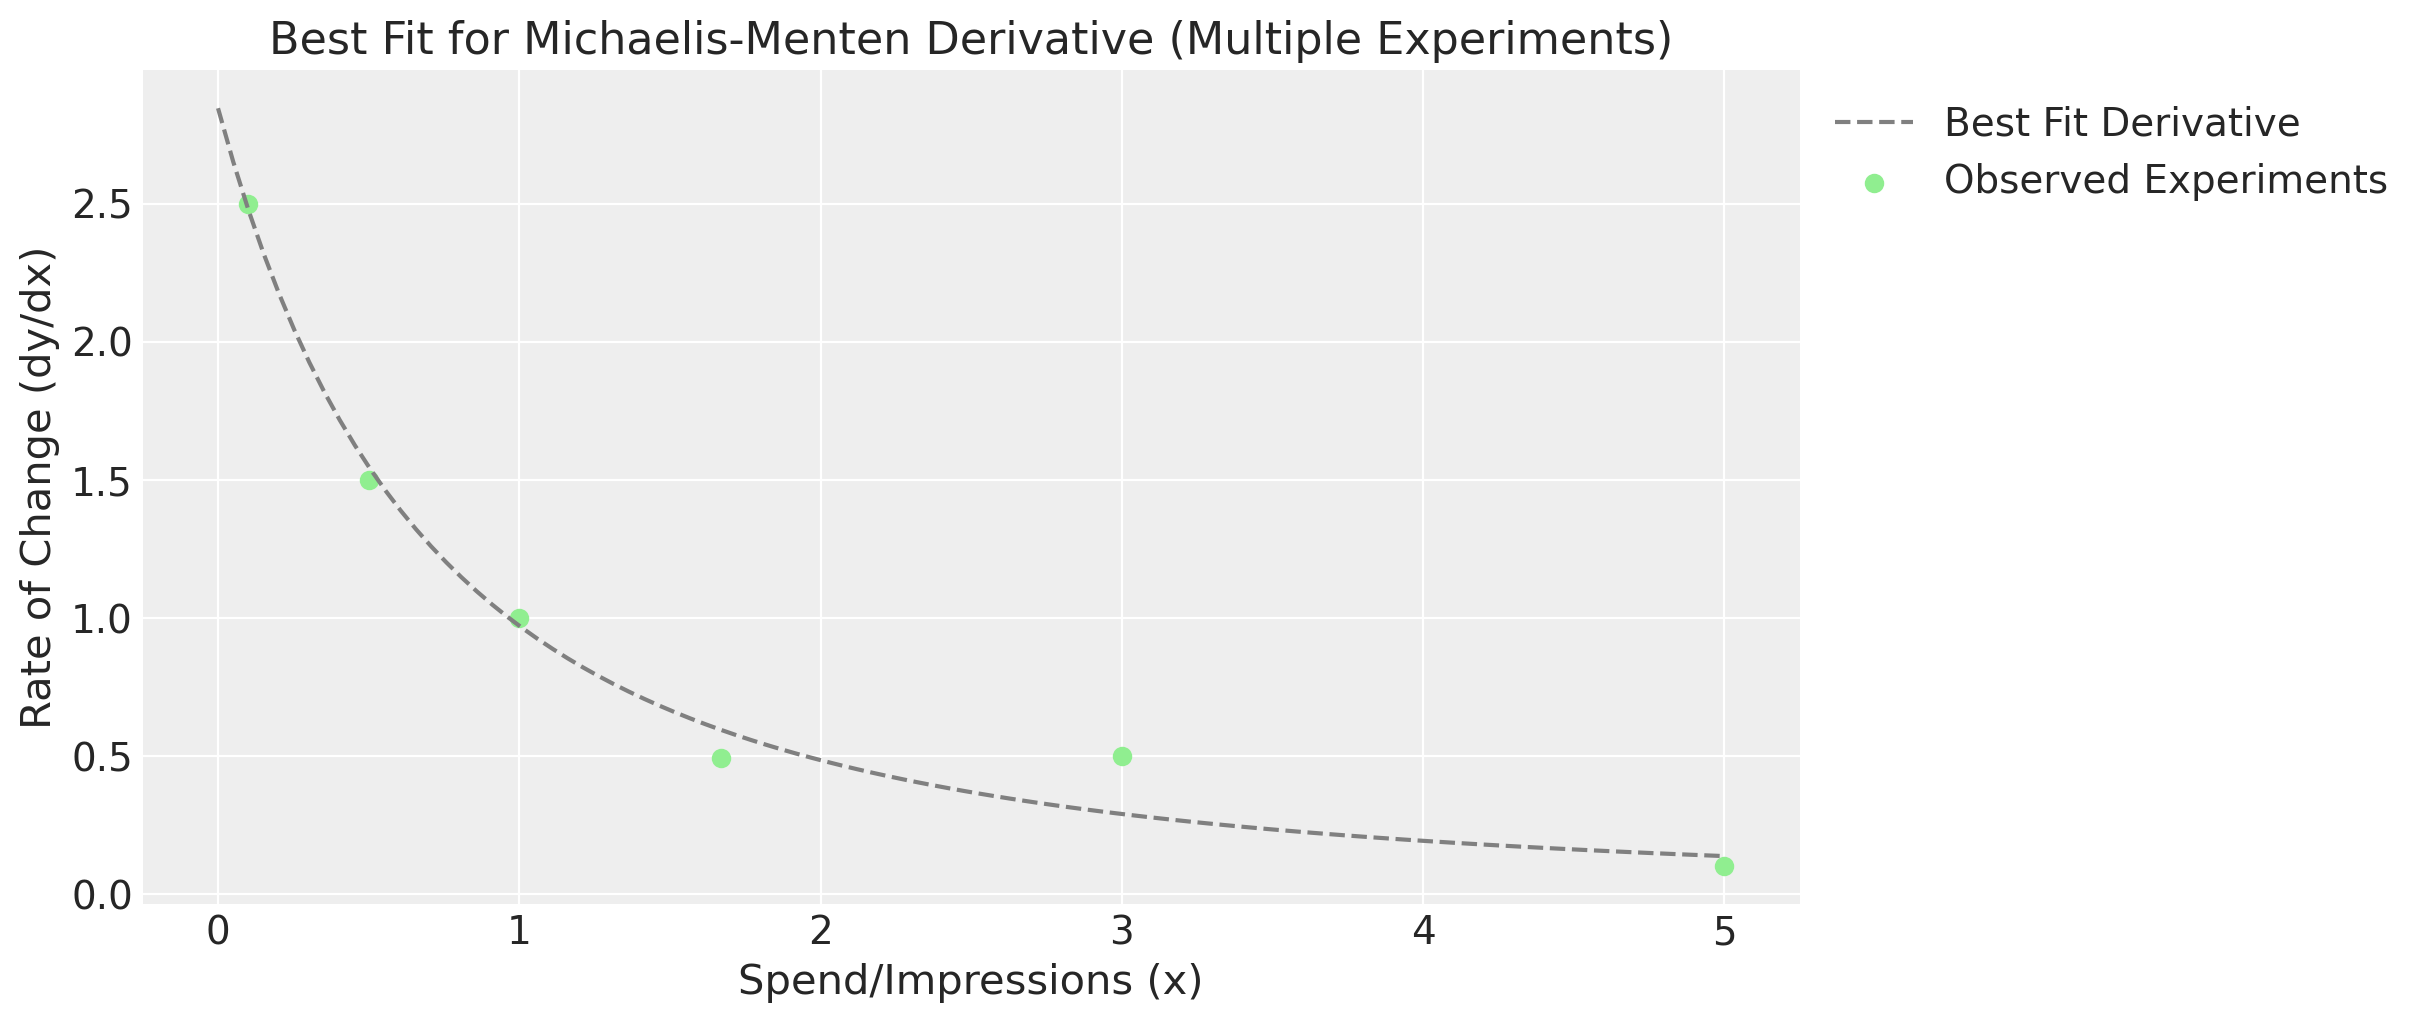

In [36]:
# fake data point: (x, dy/dx)
x_range = np.linspace(0, 5, 100)
initial_guess = [5, 2]
experiment_data = np.array([
    (x_midpoint, average_rate_of_change), # Experiment 1.
    (1,1), # Experiment 2.
    (.5, 1.5), # Experiment 3.
    (3, .5), # Experiment 4.
    (5, .1), # Experiment 5.
    (.1, 2.5) # Experiment 6.
])

# Perform optimization with a single point
result_single = minimize(objective_function, initial_guess, args=(experiment_data[:, 0], experiment_data[:, 1]), method='L-BFGS-B', bounds=[(0, None), (0, None)])

# Extract the best alpha and lambda for the single point
best_alpha_single, best_lam_single = result_single.x

# Plot the observed point and the best fit line for the single point
best_fit_y_single = derivative_michaelis_menten(x_range, best_alpha_single, best_lam_single)

print("Best Alpha for Single Point:", best_alpha_single)
print("Best Lambda for Single Point:", best_lam_single)

plt.figure(figsize=(12, 5))
plt.plot(x_range, best_fit_y_single, label="Best Fit Derivative", color="grey", linestyle="--")
plt.scatter(experiment_data[:, 0], experiment_data[:, 1], label="Observed Experiments", color="lightgreen")
plt.xlabel("Spend/Impressions (x)")
plt.ylabel("Rate of Change (dy/dx)")
plt.title("Best Fit for Michaelis-Menten Derivative (Multiple Experiments)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.show()

We just showed how to come up with useful priors for media mix models using **PyMC-Marketing** and experiments. By using causal analysis with `CausalPy`, we can figure out "what if" scenarios and estimate how marketing activities contribute to sales. This can help us get better priors in Bayesian MMMs, which means we can decompose more accurately and understand the impact of our marketing efforts better.

We've given you a step-by-step guide to using Bayesian methods and causal inference in your marketing analysis. This should help you make more informed decisions and optimize your marketing strategies more efficiently.

Now it's your turn to put this knowledge into practice and give us your feedback. We're always looking to improve!
